In [1]:
""" Load some libs """
""" python 2 lib using networkx """
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import random
import math
import pandas as pd
import statsmodels.api as sm
import scipy.stats as s
import glob
import os
import numpy as np
from PIL import Image
from helpers import *
from sklearn import linear_model
from scipy.optimize import minimize, curve_fit
from scipy.misc import factorial
import pickle
from collections import OrderedDict
import time
import copy
import ternary
#random.seed(100)
#tic = time.time()

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
""" Let's see what WEPPS we have """
folders = sorted(glob.glob('WEPP_FILES/*'))
print folders


['WEPP_FILES/2004-Q4-DEC', 'WEPP_FILES/2007-Q4-DEC', 'WEPP_FILES/2008-Q4-DEC', 'WEPP_FILES/2009-Q4-DEC', 'WEPP_FILES/2010-Q4-DEC', 'WEPP_FILES/2011-Q3-SEP', 'WEPP_FILES/2012-Q4-DEC', 'WEPP_FILES/2013-Q4-DEC', 'WEPP_FILES/2014-q4-dec', 'WEPP_FILES/2015-Q1-MAR', 'WEPP_FILES/2015-Q2-JUN', 'WEPP_FILES/2015-Q4-DEC', 'WEPP_FILES/2015-q3-sep', 'WEPP_FILES/2016-Q1-APR', 'WEPP_FILES/2016-Q2-JUL', 'WEPP_FILES/2016-Q3-SEP', 'WEPP_FILES/2016-Q4-DEC', 'WEPP_FILES/2017-Q1-MAR', 'WEPP_FILES/2017-Q2-JUL', 'WEPP_FILES/2017-Q3-SEP', 'WEPP_FILES/2017-Q4-DEC']


In [3]:
""" let's get all the WEPP dbs"""

wepps = [
    'WEPP_FILES/2007-Q4-DEC',
    'WEPP_FILES/2008-Q4-DEC',
    'WEPP_FILES/2009-Q4-DEC',
    'WEPP_FILES/2010-Q4-DEC',
    #'WEPP_FILES/2011-Q3-SEP',
    #'WEPP_FILES/2012-Q4-DEC',
    #'WEPP_FILES/2013-Q4-DEC',
    #'WEPP_FILES/2014-q4-dec',
    ##'WEPP_FILES/2015-Q1-MAR',
    ##'WEPP_FILES/2015-Q2-JUN',
    ##'WEPP_FILES/2015-q3-sep',
    #'WEPP_FILES/2015-Q4-DEC',
    ##'WEPP_FILES/2016-Q1-APR',
    ##'WEPP_FILES/2016-Q2-JUL',
    ##'WEPP_FILES/2016-Q3-SEP',
    #'WEPP_FILES/2016-Q4-DEC',
    ##'WEPP_FILES/2017-Q1-MAR',
    ##'WEPP_FILES/2017-Q2-JUL',
    ##'WEPP_FILES/2017-Q3-SEP',
    #'WEPP_FILES/2017-Q4-DEC']
]

years = range(2007,2011)
#print years

wepps_dict = dict(zip(years,wepps))

print wepps_dict

wepp_dfs = {}

for y in years:
    wepp_dfs[y] = get_wepp(wepps_dict[y])
    

{2008: 'WEPP_FILES/2008-Q4-DEC', 2009: 'WEPP_FILES/2009-Q4-DEC', 2010: 'WEPP_FILES/2010-Q4-DEC', 2007: 'WEPP_FILES/2007-Q4-DEC'}


In [4]:
""" fix all the wepp stuff, fix categories, interpolate dates, add all the columns """
def prep_wepp(wepp_df):
    # merge with ISO, country budgets and load factors 
    print '~~~~~~ GENERATING DF ~~~~~~~'
    print 'loading df...'
    df_iso = pd.read_csv('country_ISO_update.csv')
    fuel_class = 'fuel_classification_database.dta'
    df_fuel_class = pd.io.stata.read_stata(fuel_class)
    heat_rates_xls = 'Heat rates_v3.xls'
    df_heatrates = pd.read_excel(heat_rates_xls, sheet_name='CSV_output')
    df_load_factor = pd.io.stata.read_stata('load_factor_database.dta')

    print 'loaded dfs: '
    print 'merging dfs and filling missing years...'
    #df_fuel_load = pd.merge(df_fuel_class, df_load_factor, on='fuel_class')
    #print df_iso
    #print df_fuel_class
    #print df_heatrates
    #print df_load_factor
    #print list(wepp_df)
    #print wepp_df['FUEL']

    df_fuel_class.rename(columns = {'fuel': 'FUEL'}, inplace = True)
    
    #fix fuel classes
    wepp_df = wepp_df.merge(df_fuel_class, on='FUEL', how='left')
    df_wepp_em_fact = pd.read_csv('wepp_em_fact.csv')

    #merge emissions factors
    wepp_df = wepp_df.merge(df_wepp_em_fact, left_on='FUEL', right_on='fuel', how='left')

    #prepare lookup indexer
    wepp_df['FORMAT_HR'] = wepp_df.apply(lambda row: format_hr(row), axis=1)

    #standardise statuses
    wepp_df.loc[wepp_df.STATUS=='DEF', 'STATUS'] = 'PLN'
    wepp_df.loc[wepp_df.STATUS=='DEL', 'STATUS'] = 'CON'
    wepp_df.loc[wepp_df.STATUS=='UNK', 'STATUS'] = 'PLN'
    wepp_df.loc[wepp_df.STATUS=='DAC', 'STATUS'] = 'STN'

    #print  list(df_iso)

    #add ISO
    wepp_df = wepp_df.merge(df_iso[['Caps','ISO','Region']], left_on='COUNTRY', right_on='Caps', how='left')

    #fill in missing years
    all_training = wepp_df[['YEAR','fuel_class','STATUS','Region','FORMAT_HR']]
    all_training['fuel_class'] = all_training['fuel_class'].astype('category')
    all_training['STATUS'] = all_training['STATUS'].astype('category')
    all_training['Region'] = all_training['Region'].astype('category')
    all_training['FORMAT_HR'] = all_training['FORMAT_HR'].astype('category')
    all_training = pd.get_dummies(all_training[['YEAR','fuel_class','STATUS','Region','FORMAT_HR']], columns = ['fuel_class','STATUS','Region','FORMAT_HR'])

    year_train_X = all_training[all_training.YEAR.notnull()].drop('YEAR', axis=1)
    year_train_Y = all_training.loc[all_training.YEAR.notnull(),'YEAR']
    year_train_X = sm.add_constant(year_train_X)

    test_data = all_training.loc[all_training.YEAR.isnull()].drop('YEAR', axis=1)
    test_data = sm.add_constant(test_data)

    est = sm.OLS(year_train_Y, year_train_X)
    est = est.fit()

    wepp_df['YEAR_EST_FLAG'] = 0
    wepp_df.loc[wepp_df.YEAR.isnull(),'YEAR_EST_FLAG'] = 1
    wepp_df.loc[wepp_df.YEAR.isnull(),'YEAR'] = est.predict(test_data)
    


    #get heatrates
    wepp_df = wepp_df.merge(df_heatrates, left_on='FORMAT_HR', right_on='unique_id', how='left')
    wepp_df['HEATRATE'] = wepp_df.apply(lambda row: get_hr(row), axis=1)
    drop_cols = [col for col in list(wepp_df) if isinstance(col,int)]
    wepp_df.drop(drop_cols, axis=1, inplace=True)

    #get CO2 int, CCCE
    wepp_df = wepp_df.merge(df_load_factor, on='fuel_class', how='left')
    wepp_df['YEARS_LEFT'] = np.where(wepp_df['STATUS']=='OPR', wepp_df['YEAR']+40-2017, 0)
    wepp_df.YEARS_LEFT.clip(lower=0.0, inplace=True) #set min years left to 0
    print 'dfs merged and interped: '


    print 'calculating carbon and MWs...'

    wepp_df['CO2_INT'] = wepp_df['em_fact'] /2.205 * wepp_df['HEATRATE'] / 1000
    wepp_df['CCCE'] = 8760 * wepp_df['MW'] * wepp_df['YEARS_LEFT'] * wepp_df['load_factor'] * wepp_df['CO2_INT'] /1000 #tonnes 
    #wepp_df.sort_values('CCCE', inplace=True)

    #print wepp_df
    #print list(wepp_df)
    #print wepp_df.CCCE


    #print all_countries
    #exit()

    #sort WEPP
    wepp_df.sort_values('CCCE', inplace=True, ascending=False)

    wepp_df['green']=wepp_df.fuel_class.isin(['SUN','BIOGAS','WASTE','BIOOIL','WIND','BIOMASS','GEOTHERMAL'])
    wepp_df['green_MW'] = wepp_df.MW*wepp_df.green
    wepp_df['blue']=wepp_df.fuel_class.isin(['WATER','NUCLEAR'])
    wepp_df['blue_MW'] = wepp_df.MW*wepp_df.blue
    wepp_df['solar']=wepp_df.fuel_class.isin(['SUN'])
    wepp_df['solar_MW'] = wepp_df.MW*wepp_df.solar
    wepp_df['wind']=wepp_df.fuel_class.isin(['WIND'])
    wepp_df['wind_MW'] = wepp_df.MW*wepp_df.wind
    wepp_df['ff']=~wepp_df.fuel_class.isin(['SUN','BIOGAS','WASTE','BIOOIL','WIND','BIOMASS','GEOTHERMAL','WATER','NUCLEAR'])
    wepp_df['ff_MW'] = wepp_df.MW*wepp_df.ff
    
    return wepp_df

In [5]:
for y in years:
    wepp_dfs[y] = prep_wepp(wepp_dfs[y])

~~~~~~ GENERATING DF ~~~~~~~
loading df...
loaded dfs: 
merging dfs and filling missing years...


/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

dfs merged and interped: 
calculating carbon and MWs...
~~~~~~ GENERATING DF ~~~~~~~
loading df...
loaded dfs: 
merging dfs and filling missing years...
dfs merged and interped: 
calculating carbon and MWs...
~~~~~~ GENERATING DF ~~~~~~~
loading df...
loaded dfs: 
merging dfs and filling missing years...
dfs merged and interped: 
calculating carbon and MWs...
~~~~~~ GENERATING DF ~~~~~~~
loading df...
loaded dfs: 
merging dfs and filling missing years...
dfs merged and interped: 
calculating carbon and MWs...


In [6]:
for y in years:
    #print list(wepp_dfs[y])
    wepp_dfs[y] = wepp_dfs[y][['UNIT','PLANT','COMPANY','MW','STATUS','YEAR','UNITID','fuel_class','ISO','CO2_INT','CCCE','green','green_MW','blue','blue_MW','solar', 'solar_MW', 'wind', 'wind_MW', 'ff', 'ff_MW']]

In [7]:
for y in years:
    #print wepp_dfs[y]['STATUS']!='OPR'
    wepp_dfs[y].STATUS = wepp_dfs[y].STATUS.str.upper()
    wepp_dfs[y].drop(wepp_dfs[y][wepp_dfs[y]['STATUS']!='OPR'].index, inplace=True)
    print wepp_dfs[y].STATUS.unique()

[u'OPR']
[u'OPR']
[u'OPR']
[u'OPR']


In [8]:
select_iso = 'GB'

iso_slice = {}
iso_slice_plants = {}
iso_slice_meta = {}

for y in years:
    iso_slice[y] = wepp_dfs[y][wepp_dfs[y].ISO==select_iso]
    
    iso_slice_plants[y] = iso_slice[y][['PLANT','COMPANY']].groupby(['PLANT']).agg(lambda x:x.value_counts().index[0])

    print iso_slice[y].loc[pd.isnull(iso_slice[y].fuel_class),['fuel_class']]
    iso_slice[y].loc[pd.isnull(iso_slice[y].fuel_class),['fuel_class']]='OIL'

    iso_slice_plants[y]['fuel_class'] = iso_slice[y][['PLANT','fuel_class']].groupby(['PLANT']).agg(lambda x:x.value_counts().index[0])
    iso_slice_plants[y]['YEAR'] = iso_slice[y][['PLANT','YEAR']].groupby(['PLANT']).mean()

    for c in ['green','blue','solar','wind','ff']:
        iso_slice_plants[y][c] = iso_slice[y][['PLANT',c]].groupby(['PLANT']).agg(lambda x:x.value_counts().index[0])

    for c in ['MW','CCCE','green_MW','blue_MW','solar_MW','wind_MW','ff_MW']:
        iso_slice_plants[y][c] = iso_slice[y][['PLANT',c]].groupby(['PLANT']).sum()

    
    iso_slice_meta[y] = iso_slice_plants[y][['COMPANY','MW']].groupby(['COMPANY']).sum()
    iso_slice_meta[y]['COUNT'] = iso_slice_plants[y][['COMPANY','MW']].groupby(['COMPANY']).count()
    for c in ['CCCE','green_MW','blue_MW','solar_MW','wind_MW','ff_MW']:
        iso_slice_meta[y][c] = iso_slice[y][['COMPANY',c]].groupby(['COMPANY']).sum()

    
    #by MW sum
    #companies_ordered = list(wepp_slice_plants[['COMPANY','MW']].groupby(['COMPANY']).sum().sort_values('MW', ascending=False).index)

    #by number of plants
    #companies_ordered = list(wepp_slice_plants[['COMPANY','MW']].groupby(['COMPANY']).count().sort_values('MW', ascending=False).index)
    #print companies_ordered

       fuel_class
87456         NaN
117105        NaN
117106        NaN


/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


       fuel_class
92874         NaN
124405        NaN
124406        NaN
       fuel_class
131598        NaN
131599        NaN
       fuel_class
139405        NaN
139406        NaN


In [9]:
# correct solution:
def softmax(x, ax=0):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=ax) # only difference

In [42]:
### GENERATE NEW PLANTS AND TRAIN ATTACHMENT REGRESSORS ###

new_assets = {}
logreg = {}

retired_plants = {}
extra_plants = {}
epsilons = {}
new_plants = {}

for y in years[1:]:
    
    epsilons[y] = {}
    
    
    ### GENERATE NEW PLANTS - BASED ON PR_G/B/FF, WEIBULL SIZE DIST, 
       
    new_plants_ini = [p for p in iso_slice[y].PLANT.unique() if p not in iso_slice[y-1].PLANT.unique()]
    
    #print iso_slice_plants[y].ix[new_plants_ini]
    
    ADD_MW_ALL = iso_slice_plants[y].ix[new_plants_ini].MW.sum()
    new_plants[y] = list(iso_slice_plants[y].ix[new_plants_ini].loc[np.abs(iso_slice_plants[y].ix[new_plants_ini].YEAR-y)<5.0].index.values)

    extra_plants[y] = [p for p in new_plants_ini if p not in new_plants[y]]
    print extra_plants[y]
    
    for c in ['green_MW','blue_MW','ff_MW']:
        epsilons[y][c] = len([p for p in new_plants[y] if (iso_slice_plants[y].at[p,c]>10**-4.0)&(iso_slice_plants[y].at[p,'COMPANY'] not in iso_slice_plants[y-1].COMPANY.unique())])/float(len(new_plants[y]))
    
    retired_plants[y] = [p for p in iso_slice[y-1].PLANT.unique() if p not in iso_slice[y].PLANT.unique()]
    #print retired_plants
    new_units = [p for p in iso_slice[y].UNITID.unique() if p not in iso_slice[y-1].UNITID.unique()]

    #print iso_slice_plants[y].ix[new_plants].loc[iso_slice_plants[y].ix[new_plants].green==True].sort_values('green_MW')
    ADD_MW = iso_slice_plants[y].ix[new_plants[y]].MW.sum()
    print 'add_MW', ADD_MW, 'all added MW', ADD_MW_ALL, 'retired MW', iso_slice_plants[y-1].ix[retired_plants[y]].MW.sum()
    
    #static model - reproduce distribution for each time step just to test preferential attachment model
    Pr_green = len(iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].green==True])/float(len(new_plants[y]))
    Pr_blue = len(iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].blue==True])/float(len(new_plants[y]))
    Pr_ff = len(iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].ff==True])/float(len(new_plants[y]))
    
    #print iso_slice_plants[y].ix[new_plants].loc[iso_slice_plants[y].ix[new_plants].blue==True]
    print Pr_green, Pr_blue, Pr_ff
    
    reso = {}
    
    #use full population for size of asset
    #print 'green, blue, ff plants', (iso_slice_plants[y-1].green==True).sum(), (iso_slice_plants[y-1].blue==True).sum(), (iso_slice_plants[y].ff==True).sum() 
    #reso['g'] = s.exponweib.fit(iso_slice_plants[y-1][iso_slice_plants[y-1].green==True].MW.values,floc=0, fa=1)
    #reso['b'] = s.exponweib.fit(iso_slice_plants[y-1][iso_slice_plants[y-1].blue==True].MW.values,floc=0, fa=1)
    #reso['f'] = s.exponweib.fit(iso_slice_plants[y-1][iso_slice_plants[y-1].ff==True].MW.values,floc=0, fa=1)
    
    reso['g'] = s.exponweib.fit(iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].green==True].MW.values)#, floc=0, fa=1)
    reso['b'] = s.exponweib.fit(iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].blue==True].MW.values)#,floc=0, fa=1)
    reso['f'] = s.exponweib.fit(iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].ff==True].MW.values)#,floc=0, fa=1)
    
    data = iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].green==True].MW.values
    
    print reso['g']
    print reso['b']
    print reso['f']
    
    
    new_assets[y] = []
    
    NEW_MW=0.0
    
    while NEW_MW<=ADD_MW:
        c = np.random.choice(['g','b','f'],p=np.array([Pr_green,Pr_blue,Pr_ff])/np.sum([Pr_green,Pr_blue,Pr_ff]))
        MW = s.exponweib.rvs(*reso[c],size=1)[0]
        new_assets[y].append({'color':c, 'MW':MW})
        NEW_MW +=MW
        
    #print max([n['MW'] for n in new_assets[y]])
    #print len(new_assets[y])
    #print list(iso_slice_plants[y].ix[new_plants])
    
    X = []
    
    
    ### train the attachment model
    for jj in range(len(new_plants[y])):
        
    
        ###Ex-post for the regressor
        x = iso_slice_plants[y][['COMPANY','MW']].groupby('COMPANY').count()
        x = x.rename(columns={'MW':'n_plants'})
        for c in ['green','blue','ff','green_MW','blue_MW','ff_MW','MW']:
            x[c] = iso_slice_plants[y][['COMPANY',c]].groupby('COMPANY').sum().astype(float)
        
        #x = x.rename(columns=dict(zip(['green','blue','ff'],['n_green','n_blue','n_ff'])))
        x['Y']=0.0
        x.loc[iso_slice_plants[y].at[new_plants[y][jj],'COMPANY'],'Y']=1
        #print x.ix[iso_slice_plants[y].at[new_plants[jj],'COMPANY']]
        
        #remove the stuff from the selected one
        x.loc[iso_slice_plants[y].at[new_plants[y][jj],'COMPANY'],'n_plants']-=1.0
        
        #print iso_slice_plants[y].ix[new_plants[jj]]
        for c in ['green','blue','ff','green_MW','blue_MW','ff_MW','MW']:
            #print c
            #print x.loc[iso_slice_plants[y].at[new_plants[jj],'COMPANY']]
            #print 'bf',x.loc[iso_slice_plants[y].at[new_plants[jj],'COMPANY'],c]
            x.loc[iso_slice_plants[y].at[new_plants[y][jj],'COMPANY'],c] -= iso_slice_plants[y].at[new_plants[y][jj],c]
            #print 'after',x.loc[iso_slice_plants[y].at[new_plants[jj],'COMPANY'],c]
            
        for c in ['green','blue','ff']:
            x['n%_'+c] = x[c]/x['n_plants'].astype(float)
            x['MW%_'+c] = x[c.split('_')[0]+'_MW']/x['MW'].astype(float)
            
            
        x['add_MW'] = iso_slice_plants[y].at[new_plants[y][jj],'MW']
        x['add_green%'] = iso_slice_plants[y].at[new_plants[y][jj],'green_MW']/iso_slice_plants[y].at[new_plants[y][jj],'MW']
        x['add_blue%'] = iso_slice_plants[y].at[new_plants[y][jj],'blue_MW']/iso_slice_plants[y].at[new_plants[y][jj],'MW']
        x['add_ff%'] = iso_slice_plants[y].at[new_plants[y][jj],'ff_MW']/iso_slice_plants[y].at[new_plants[y][jj],'MW']
            
        x.fillna(0.0, inplace=True)
        
        ## cross features
        for c_i in ['n_plants', 'green', 'blue', 'ff', 'green_MW', 'blue_MW', 'ff_MW', 'MW', 'n%_green', 'MW%_green', 'n%_blue', 'MW%_blue', 'n%_ff', 'MW%_ff']:
            for c_o in ['add_MW', 'add_green%', 'add_blue%', 'add_ff%']:
                x[str(c_i)+'_x_'+str(c_o)] = x[c_i]*x[c_o]
        
        X.append(x)
        
        
    X = pd.concat(X)
    #print 'X shape', X.shape
    
    x_cols = list(X)
    #print 'x_cols', x_cols
    Y_trn = X['Y'].values
    #print 'ysum', np.sum(Y_trn)
    x_cols.pop(x_cols.index('Y'))
    X_trn = X.as_matrix(columns=x_cols)
    print X_trn.shape
    print Y_trn.shape
    
    logreg[y] = linear_model.LogisticRegression()

    logreg[y].fit(X_trn, Y_trn)
    
    
    #logit_model=sm.Logit(Y,X)
    #result=logit_model.fit()
    #print(result.summary())
    #print logreg[y].coef_.shape
    #print len(x_cols)
    
    model_coeffs = dict(zip(x_cols,list(np.squeeze(logreg[y].coef_))))
    for m in sorted(model_coeffs.iteritems(), key=lambda x:x[1]):
        print m
    
    #print X.shape, list(X)
    #print iso_slice_plants[y].ix[new_plants].ff
    



    
    #then - global, fixed-effect model
    
    ### fit with color
    #input_features = OrderedDict()
    #input_features = {
    #    'n_plants': len(iso_slice_plants[y-1]),
    #    'n_companies':len(iso_slice_plants[y-1].COMPANY.unique()),
    #    'n%_green':(iso_slice_plants[y-1].green==True).sum()/float(len(iso_slice_plants[y-1].COMPANY.unique())),
    #    'n%_blue':(iso_slice_plants[y-1].blue==True).sum()/float(len(iso_slice_plants[y-1].COMPANY.unique())),
    #    'n%_ff':(iso_slice_plants[y-1].ff==True).sum()/float(len(iso_slice_plants[y-1].COMPANY.unique())),
    #    'MW_total':(iso_slice_plants[y-1].MW).sum(),
    #    'MW%_green':(iso_slice_plants[y-1].green_MW.sum()/float(iso_slice_plants[y-1].MW.sum())),
    #    'MW%_blue':(iso_slice_plants[y-1].blue_MW.sum()/float(iso_slice_plants[y-1].MW.sum())),
    #    'MW%_ff':(iso_slice_plants[y-1].ff_MW.sum()/float(iso_slice_plants[y-1].MW.sum())),
    #    'MW_mean':(iso_slice_plants[y-1].MW).mean(),
    #    'MW_median':(iso_slice_plants[y-1].MW).median(),
    #}
    #print input_features
    #print iso_slice_plants[y].ix[new_plants]
    #Y_g = iso_slice_plants[y].ix[new_plants].green
    #print Y_g.astype(float)
    
    

[u'AVONMOUTH LNG', u'DAN Y BRYN HOME', u'AFON IWRCH REBUILD', u'AFON TY-CERIG', u'ARDVERIKIE', u'ASHFIELD MILL', u'AVON DAM', u'AWE BARRAGE', u'BALGONIE', u'BERRIEDALE', u'BLACKBURN WWTP', u'BRIDGE OF TILT', u'BROUGHTON WWTP', u'BURNHEAD', u'CARRICKANESS', u'CLACHBRECK', u'CLATTO WWTP', u'CLUANIE DAM', u'CLUNIE DAM', u'CROSSNESS WWTP', u'CROWNHILL WWTP', u'CWM CROESOR REBUILD', u'DEANSTON', u'DERWENT RESERVOIR', u'DINAS DAM', u'DOLGARROG HIGH', u'DOLGARROG LOW', u'DRIMSYNIE ESTATE', u'ELAN CLAERWEN', u'ERRWOOD RESERVOIR', u'EWDEN WWTP', u'FAIRBURN ORRIN FALLS', u'FETTYKIL MILLS', u'GARBHAIG', u'GAYLE MILL', u'HUNTERSTON B', u'ISLEWORTH ORMISTON', u'LADYGROVE PRIMARY SCHOOL', u'LOCHABER', u'MISGEACH', u'RUSHCLIFFE EEC', u'SHELL GREEN', u'STORMONTFIELD', u"TEBBUTT'S FARM", u'TRINAFOUR']
add_MW 845.577 all added MW 2313.61 retired MW 1487.743
0.741379310345 0.206896551724 0.051724137931
(1.1494787040136729, 0.48401439215214392, 0.0059999999999999993, 10.04645148976735)
(1.2675340209384731

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[u'UNIVERSITY OF LIVERPOOL', u'GOSPORT WORKS', u'MARRIOT HEATHROW', u'HULL INFIRMARY', u'WINDSOR LEISURE', u'AVONMOUTH SEVALCO', u'HILLHOUSE VICTREX', u'ACHAMORE FARM', u'ALLERTON PARK LANDFILL', u'CLATTO WTW', u'EIGG SOLAR', u'EIGG-2', u'HEARTHSTANES BURN', u'NEW LANARK MILL 3', u'OXFORD STW', u'TEESSIDE SITA']
add_MW 1637.771 all added MW 1716.32 retired MW 177.435
0.666666666667 0.0909090909091 0.257575757576
(0.84898848661252879, 0.64033117701399167, 0.0059999999999999993, 14.760504151391849)
(1.2135405850689407, 0.47793813285411563, 0.0069999999999999984, 0.28072499435936826)
(0.94796972448636097, 0.53637798880026721, 0.0059999999999999993, 6.8095433486195978)
(52404, 74)
(52404,)
('n_plants_x_add_MW', -0.0038055591774298603)
('add_MW', -0.0030520021607596797)
('MW', -0.00277891013240879)
('ff_x_add_MW', -0.0022492641145917874)
('n%_ff_x_add_MW', -0.0018502461270943082)
('MW%_ff_x_add_MW', -0.0018389847728248929)
('ff_MW', -0.0016352569675516582)
('MW_x_add_green%', -0.00137323183

[  2.30600000e+00   4.80000000e+01   2.30000000e+01   4.20000000e+00
   2.60000000e+01   8.00000000e+00   2.60000000e+01   2.70000000e+00
   8.00000000e-03   1.00000000e-02   1.13600000e+00   3.61000000e+01
   2.00000000e+01   1.50000000e+01   3.00000000e+01   1.00000000e+00
   4.14000000e+01   8.00000000e-01   1.50000000e+01   2.20000000e+00
   1.60000000e+01   5.00000000e-01   2.70000000e+01   1.72800000e+02
   1.02500000e+01   8.00000000e-01   8.70000000e+00   3.20000000e+00
   9.00000000e-01   2.00000000e+01   3.89500000e+01   5.00000000e+00
   8.00000000e-01   2.20000000e+01   1.00000000e-01   1.80000000e+02
   1.76000000e+00   1.00000000e-02   6.90000000e+00   3.00000000e+02
   1.75000000e+01   1.30000000e-02   2.40000000e+01   9.00000000e-01
   1.80000000e+00   2.00000000e-01]
(0.20713832331724286, 0.0079999999999999984, 305.10349382509298)
(0.98349194842695942, 0.48966206793360645, 0.0079999999999999984, 27.26569453444257)


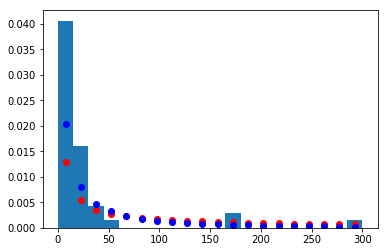

In [47]:
print data

fit_pl = s.powerlaw.fit(data)#, floc=0, f0=1)
fit_wb = s.exponweib.fit(data)#, floc=0, f0=1)
print fit_pl
print fit_wb
    
values, bins, hist = plt.hist(data, density=True, bins = 20)
center = (bins[:-1] + bins[1:]) / 2.
x = np.linspace(data.min(), data.max(), 100)
plt.plot(center,s.powerlaw.pdf(center,*fit_pl), 'ro', lw=2)
plt.plot(center,s.exponweib.pdf(center,*fit_wb), 'bo', lw=2)
#print reso['g']
#print reso['b']
#print reso['f']
    
plt.show()

In [11]:
### get policy data

df_policy_all = pd.read_csv('policy_df.csv', encoding='utf-8')
#print df_policy

harmon_dict = {
        'SALES & OTHER TAX CREDITS': 'SALES_TAX_CREDIT', 
        'BIOFUELS MANDATE':'BIOFUEL_TRANSPORT_MANDATE', 
        'RPS':'RPS', 
        'TENDERING':'TENDERING', #== public competitive bidding
        'INVESTMENT & TAX CREDITS':'INVESTMENT_TAX_CREDIT', 
        'TRADEABLE RECS':'TRADEABLE_RECS', 
        'FIT':'FIT', 
        'PUBLIC INVESTMENT/FINANCE/GRANTS':'PUBLIC_INVESTMENT', 
        'ENERGY PRODUCTION PAYMENTS':'ENERGY_PRODUCTION_PAYMENTS', 
        'PUBLIC INVESTMENT/FINANCE/GRANTS/SUBSIDIES':'PUBLIC_INVESTMENT', #2017 only - grants, capital subsidies merged with public investment/finance
        'RENEWABLE ENERGY TARGET':'RENEWABLE_ENERGY_TARGET', 
        'RENEWABLE ENERGY NDC':'RE_IN_NDC',
        'TRANSPORT / BIOFUELS MANDATE':'BIOFUEL_TRANSPORT_MANDATE', 
        'PUBLIC INVESTMENT/FINANCE':'PUBLIC_INVESTMENT', 
        'CAPITAL SUBSIDY':'SUBSIDIES_GRANTS', 
        'NET METERING':'NET_METERING', 
        'GRANTS':'SUBSIDIES_GRANTS', #= capital subsidy
        'HEAT MANDATE':'HEAT_MANDATE', 
        'PUBLIC COMPETITIVE BIDDING':'TENDERING', #public tendering 
        'TRADEABLE REC':'TRADEABLE_RECS'
        }

policies = list(set([v for k,v, in harmon_dict.items()]))
persistant_policies = [
    u'2007_FIT', u'2007_RPS', u'2007_INVESTMENT_TAX_CREDIT', 
    u'2007_SALES_TAX_CREDIT', u'2007_TRADEABLE_RECS', u'2007_ENERGY_PRODUCTION_PAYMENTS', 
    u'2007_NET_METERING', u'2007_PUBLIC_INVESTMENT', u'2007_TENDERING',
]
persistant_policies = ['_'.join(p.split('_')[1:]) for p in persistant_policies]

df_policy_iso = pd.DataFrame(index=persistant_policies, columns=years)

for y in years:
    if (y ==2008) or (y==2009):
        for p in persistant_policies:
            df_policy_iso.loc[p,y] = df_policy_all.loc[df_policy_all.iso2==select_iso, str(2007)+'_'+p].values[0]
    else:
        for p in persistant_policies:
            df_policy_iso.loc[p,y] = df_policy_all.loc[df_policy_all.iso2==select_iso, str(y)+'_'+p].values[0]
            
print [((y-min(years))/float((max(years)-min(years)))) for y in years]


df_temp = pd.DataFrame([dict(zip(years,[((y-min(years))/float((max(years)-min(years)))) for y in years]))], columns=years)
df_temp['YEAR'] = 'YEAR'
df_temp = df_temp.set_index('YEAR', drop=True)
print df_temp

df_policy_iso = df_policy_iso.append(df_temp)
print df_policy_iso
            

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
      2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017
YEAR                                                                  
YEAR   0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.0
                            2007  2008  2009  2010  2011  2012  2013  2014  \
FIT                          0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
RPS                          1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
INVESTMENT_TAX_CREDIT        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
SALES_TAX_CREDIT             1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
TRADEABLE_RECS               1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
ENERGY_PRODUCTION_PAYMENTS   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
NET_METERING                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
PUBLIC_INVESTMENT            0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
TENDERING                    

In [26]:
print iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].green==True].MW.values
print s.exponweib.fit(iso_slice_plants[y].ix[new_plants[y]].loc[iso_slice_plants[y].ix[new_plants[y]].green==True].MW.values,floc=0, fa=1)

[  8.00000000e-01   8.50000000e-01   2.30000000e+01   2.60000000e+01
   9.00000000e+00   3.90000000e+00   6.00000000e+00   1.50000000e+01
   6.00000000e-03   8.00000000e-01   1.00000000e+01   2.40000000e-01
   1.22500000e+01   3.50000000e+01   1.70000000e+00   4.60000000e+01
   4.00000000e+00   2.70000000e+01   3.90000000e+00   2.60000000e+00
   4.75000000e+01   7.00000000e-01   7.80000000e+00   3.68000000e+01
   3.00000000e+00   1.80000000e+00   1.00000000e+01   1.70000000e+00
   6.50000000e+01   2.00000000e+00   5.40000000e+01   2.50000000e+00
   4.00000000e-02   2.00000000e-02   8.00000000e-03   1.40000000e+01
   4.00000000e-02   6.50000000e+00   1.42000000e+01   1.04000000e+01
   2.09300000e+02   9.00000000e+00   1.00000000e+01]
(1, 0.55579257155137707, 0, 10.319804142933389)


In [27]:
### MAKE SOME MORE SYNTHETIC DFS

weib_params = {
    'g':(1.0,0.5,0.0,2.0),
    'b':(1.0,0.5,0.0,2.0),
    'f':(1.0,0.5,0.0,2.0)
}
Pr = {
    'g':0.33,
    'b':0.33,
    'f':0.33
}

### input params 
input_params = list(df_policy_iso.index.values)+[
    'n_green',
    'n_blue',
    'n_ff',
    'MW_green',
    'MW_blue',
    'MW_ff',
    'top_n_green',
    'top_n_blue',
    'top_n_ff',
    'top_MW_green',
    'top_MW_blue',
    'top_MW_ff',
    'BIAS',
]

print input_params


BETA = {}

for c in ['g','b','f']:
    BETA[c] = {}
    for p in ['weib_a','weib_c','pr']:
        BETA[c][p] = np.zeros((len(input_params)))
        
    BETA[c]['weib_a'][-1] = 0.5
    BETA[c]['weib_c'][-1] = 10.0
    BETA[c]['pr'][-1] = 0.33
        
print BETA

print x_cols

plant_ii = 0
company_ii = 0

synthetic_df = {}
synthetic_df[years[0]] = iso_slice_plants[years[0]]

for y in years[1:]:
    
    print y
    synthetic_df[y] = copy.deepcopy(synthetic_df[y-1])
    
    #drop retired plants
    synthetic_df[y] = synthetic_df[y][~synthetic_df[y].index.isin(retired_plants[y])]
    
    input_vector_dict = dict(zip(list(df_policy_iso.index.values),df_policy_iso.loc[:,y].values))
    input_vector_dict['n_green'] = synthetic_df[y][synthetic_df[y].green==True].green.sum()
    input_vector_dict['n_blue'] = synthetic_df[y][synthetic_df[y].blue==True].blue.sum()
    input_vector_dict['n_ff'] = synthetic_df[y][synthetic_df[y].ff==True].ff.sum()
    input_vector_dict['MW_green'] = synthetic_df[y][synthetic_df[y].green_MW>10**-4].green_MW.sum()
    input_vector_dict['MW_blue'] = synthetic_df[y][synthetic_df[y].blue_MW>10**-4].blue_MW.sum()
    input_vector_dict['MW_ff'] = synthetic_df[y][synthetic_df[y].ff_MW>10**-4].ff_MW.sum()
    input_vector_dict['top_n_green'] = synthetic_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green.sum()
    input_vector_dict['top_n_blue'] =synthetic_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).blue.sum()
    input_vector_dict['top_n_ff'] =synthetic_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green.sum()
    input_vector_dict['top_MW_green'] =synthetic_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green_MW.sum()
    input_vector_dict['top_MW_blue'] =synthetic_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).blue_MW.sum()
    input_vector_dict['top_MW_ff'] =synthetic_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).ff_MW.sum()
    input_vector_dict['BIAS']=1.0
    
    print 'meow'
    
    print input_vector_dict
    
    input_vector = np.array([input_vector_dict[k] for k in input_params])
    
    for c in ['g','b','f']:
        weib_params[c][1] = np.dot(input_vector,BETA[c]['weib_a'])
        weib_params[c][3] = np.dot(input_vector,BETA[c]['weib_c'])
        Pr[c] = np.dot(input_vector, BETA[c]['pr'])
        

    synth_new_assets[y] = []
    print reso['f']
    
    ADD_MW = iso_slice_plants[y].ix[new_plants[y]].MW.sum()
    
    NEW_MW=0.0
    
    while NEW_MW<=ADD_MW:
        
        ### GENERATE A NEW ASSET
        c = np.random.choice(['g','b','f'],p=np.array([Pr[c] for c in ['g','b','f']])/np.sum([Pr[c] for c in ['g','b','f']]))
        MW = s.exponweib.rvs(*weib_params[c], size=1)[0]
        synth_new_assets.append({'color':c,'MW':MW})
        NEW_MW+=MW
        
        
        ### PREFERENTIALLY ATTACH IT (AS IN NULL MODEL FOR NOW)
        
    
    for p in extra_plants[y]:
        synthetic_df[y] = synthetic_df[y].append(iso_slice_plants[y].ix[p])

[u'FIT', u'RPS', u'INVESTMENT_TAX_CREDIT', u'SALES_TAX_CREDIT', u'TRADEABLE_RECS', u'ENERGY_PRODUCTION_PAYMENTS', u'NET_METERING', u'PUBLIC_INVESTMENT', u'TENDERING', 'YEAR', 'n_green', 'n_blue', 'n_ff', 'MW_green', 'MW_blue', 'MW_ff', 'top_n_green', 'top_n_blue', 'top_n_ff', 'top_MW_green', 'top_MW_blue', 'top_MW_ff', 'BIAS']
{'b': {'pr': array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.33]), 'weib_c': array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        10.]), 'weib_a': array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0.5])}, 'g': {'pr': array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , 

NameError: name 'sdf' is not defined

In [28]:
print new_assets

{2016: [{'color': 'f', 'MW': 0.36219160922182947}, {'color': 'g', 'MW': 12.152624014129042}, {'color': 'g', 'MW': 8.2724083508888473}, {'color': 'g', 'MW': 14.178585565438379}, {'color': 'g', 'MW': 1.7377272013338056}, {'color': 'g', 'MW': 8.6893606783519832}, {'color': 'g', 'MW': 2.9455148290692188}, {'color': 'g', 'MW': 1.7470132290732645}, {'color': 'g', 'MW': 24.346126577276436}, {'color': 'g', 'MW': 3.9558741162619868}, {'color': 'g', 'MW': 13.6179268019412}, {'color': 'b', 'MW': 0.0011135092384805772}, {'color': 'g', 'MW': 6.6078859760681432}, {'color': 'g', 'MW': 2.5927030138919709}, {'color': 'g', 'MW': 4.8872707210086404}, {'color': 'g', 'MW': 3.5177591465048077}, {'color': 'g', 'MW': 8.690066490358598}, {'color': 'g', 'MW': 0.53487149657741384}, {'color': 'g', 'MW': 9.9873011184895208}, {'color': 'b', 'MW': 0.27238582534296729}, {'color': 'b', 'MW': 0.10313014202494993}, {'color': 'b', 'MW': 0.78558186067967861}, {'color': 'g', 'MW': 11.488397856364886}, {'color': 'b', 'MW': 

In [51]:
def random_choice_prob_index(a, axis=1):
    r = np.expand_dims(np.random.rand(a.shape[1-axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

In [96]:
### TAKE NEW ASSETS AND MAKE NULL_DFS

print x_cols

color_dict = {}
color_dict['name'] = {
    'g':'green',
    'b':'blue',
    'f':'ff'
    }
color_dict['color_arr'] = {
    'g':[1.0,0.0,0.0],
    'b':[0.0,1.0,0.0],
    'f':[0.0,0.0,1.0],
    }

plant_ii = 0
company_ii = 0

null_df = {}
null_df[years[0]] = iso_slice_plants[years[0]]

#for n in new_assets[2008]:
#    print n

for y in years[1:]:
    
    print y
    null_df[y] = copy.deepcopy(null_df[y-1])
    
    #drop retired plants
    null_df[y] = null_df[y][~null_df[y].index.isin(retired_plants[y])]
    
    cols = list(null_df[y-1])

    
    
    
    ### generate array of input data
    
    ### NULL MODEL
    #1. just size
    #1b. log10 size / sqrt size
    #2. Size and color
    #3. Cosine vs. similarity
    #4. benchmark epsilon
    #5. find weightings
    
    #epsilon=0.15
    #epsilon = epsilons[y]
    
    ###1. 
    x = null_df[y-1][['MW','COMPANY','green','blue','ff']]
    
    #x['_size'] = (np.log10(x['MW'])-np.log10(null_df[y-1]['MW'].min()))/float(np.log10(null_df[y-1]['MW'].max())-np.log10(null_df[y-1]['MW'].min()))
    x['_size'] = (x['MW']-null_df[y-1]['MW'].min())/float(null_df[y-1]['MW'].max()-null_df[y-1]['MW'].min())
    #x['_size'] = x['MW'].sort_values().cumsum()/x.MW.sum()
    x['_green'] = x['green'].astype(int)
    x['_blue'] = x['blue'].astype(int)
    x['_ff'] = x['ff'].astype(int)
    x['_norm'] = np.sqrt(np.square(x[['_size','_green','_blue','_ff']]).sum(axis=1))
    
    n = pd.DataFrame(new_assets[y])
    #n['_size'] = (np.log10(n['MW'])-np.log10(null_df[y-1]['MW'].min()))/float(np.log10(null_df[y-1]['MW'].max())-np.log10(null_df[y-1]['MW'].min()))
    n['_size'] = (n['MW']-null_df[y-1]['MW'].min())/float(null_df[y-1]['MW'].max()-null_df[y-1]['MW'].min())
    n['_green'] = (n['color']=='g').astype(int)
    n['_blue'] = (n['color']=='b').astype(int)  
    n['_ff'] = (n['color']=='f').astype(int) 
    n['_norm'] = np.sqrt(np.square(n[['_size','_green','_blue','_ff']]).sum(axis=1))
    
    for c in ['_size','_green','_blue','_ff']:
        x[c] = x[c]/x['_norm']
        n[c] = n[c]/n['_norm']
        
        
    X = x[['_size','_green','_blue','_ff']].values
    N = n[['_size','_green','_blue','_ff']].values
    
    
    ### Difference method
    X = np.stack([X for _ in range(N.shape[0])], axis=0)
    N =np.stack([N for _ in range(X.shape[1])], axis=1)
    
    P = 1.0/(((X-N)**2).sum(axis=-1))
    P = P/P.sum(axis=-1)[:, np.newaxis]
    
    
    ### COSINE SIM
    #print X.shape
    #print N.shape
    #P = (np.dot(N,X.T) +1.0) / 2.0

    #normalise P
    #P_sums = P.sum(axis=1)
    #print 'sums shape', P_sums.shape
    #P = P / P_sums[:, np.newaxis]
    #print 'P shape', P.shape
    #print 'P sum', P.sum(axis=1)
    #print 'P sum', P.sum(axis=1).shape
    
    
    select = random_choice_prob_index(P, axis=1)
    print 'selections max', select.max()
    print 'selections shape', select.shape
    
    for ii, n_a in enumerate(new_assets[y]):
        if np.random.rand()<epsilons[y][color_dict['name'][n_a['color']]+'_MW']:
            
            name = 'NEW_COMPANY_'+str(company_ii)
            company_ii+=1
            print 'new company'
        else:
            print 'n_MW: ', n_a['MW'], 'chosen_MW: ',x.iloc[select[ii]].MW, 'color:', n_a['color'], 'ch_col:', x.iloc[select[ii]].green, x.iloc[select[ii]].blue,x.iloc[select[ii]].ff
            name = x.iloc[select[ii]].COMPANY
            
        
        null_df[y] = null_df[y].append(pd.DataFrame({
            'COMPANY':name, 
            'fuel_class':'N/A_GEN', 
            'YEAR':y, 
            'green':color_dict['color_arr'][n_a['color']][0], 
            'blue':color_dict['color_arr'][n_a['color']][1], 
            'solar':0.0, 
            'wind':0.0, 
            'ff':color_dict['color_arr'][n_a['color']][2], 
            'MW':n_a['MW'], 
            'CCCE':0.0, 
            'green_MW':color_dict['color_arr'][n_a['color']][0]*n_a['MW'], 
            'blue_MW':color_dict['color_arr'][n_a['color']][1]*n_a['MW'], 
            'solar_MW':0.0, 
            'wind_MW':0.0, 
            'ff_MW':color_dict['color_arr'][n_a['color']][2]*n_a['MW'],
        }, index=['NEW_PLANT_'+str(plant_ii)]))
        
        plant_ii+=1
        
    for p in extra_plants[y]:
        null_df[y] = null_df[y].append(iso_slice_plants[y].ix[p])
    
    
    """
    
    
    
    #x['MW'] = x['MW'] #all plants
    print x
    
    for n in new_assets[y]:
        print n
        n_dict = {
            '_size':(np.log10(n['MW'])-np.log10(null_df[y-1]['MW'].min()))/float(np.log10(null_df[y-1]['MW'].max())-np.log10(null_df[y-1]['MW'].min())),
            '_green':int(n['color']=='g'),
            '_blue':int(n['color']=='b'),
            '_ff':int(n['color']=='f'),
            '_norm': np.linalg.norm(np.array([np.log10(n['MW'])/float(np.log10(null_df[y-1]['MW'].max())),1.0]))
        }
        #print n_dict
        #print np.log10(x['MW'])
        x['ndiff'] = (np.log10(x['MW'])/float(np.log10(null_df[y-1]['MW'].max())) - np.log10(n['MW'])/float(np.log10(null_df[y-1]['MW'].max())))**-2.
        x['ndiff'] = x['ndiff']/float(x['ndiff'].sum())
        
        x['_size'] = (np.log10(x['MW'])-np.log10(null_df[y-1]['MW'].min()))/float(np.log10(null_df[y-1]['MW'].max())-np.log10(null_df[y-1]['MW'].min()))
        x['_green'] = x['green'].astype(int)
        x['_blue'] = x['blue'].astype(int)
        x['_ff'] = x['ff'].astype(int)
        
        #print x[['_size','_green','_blue','_ff']]
        
        x['_norm'] = np.sqrt(np.square(x[['_size','_green','_blue','_ff']]).sum(axis=1))
        x['cosine_sim'] = ((x['_size']*n_dict['_size']+
                            x['_green']*n_dict['_green']+
                            x['_blue']*n_dict['_blue']+
                           x['_ff']*n_dict['_ff'])
                           /x['_norm']/n_dict['_norm'])
        
        x['cosine_sim'] = (x['cosine_sim']+1.0)/2.0
        
        #for c in ['_size','_green','_blue','_ff']:
        #    x[c] = x[c]/x['_norm']
        
        #print x['ndiff'].min(), (1.0-x['ndiff']).min()
        #print x['ndiff'].min()
        #print x[['MW','ndiff']]
        print 'epsilon', epsilons[y][color_dict['name'][n['color']]+'_MW']
        print x['cosine_sim']
        
        P = x['cosine_sim'].values/float(x['cosine_sim'].sum())*(1.0 - epsilons[y][color_dict['name'][n['color']]+'_MW'])
        P = np.append(P,epsilons[y][color_dict['name'][n['color']]+'_MW'])
        ii = np.random.choice(range(len(P)), p=P)
        #print len(P), ii
        if ii==(len(P)-1):
            name = 'NEW_COMPANY_'+str(company_ii)
            company_ii+=1
            print 'new company'
        else:
            print 'n_MW: ', n['MW'], 'chosen_MW: ',x.iloc[ii].MW
            name = x.iloc[ii].COMPANY

        
        #print cols
        
        
        null_df[y] = null_df[y].append(pd.DataFrame({
            'COMPANY':name, 
            'fuel_class':'N/A_GEN', 
            'YEAR':y, 
            'green':color_dict['color_arr'][n['color']][0], 
            'blue':color_dict['color_arr'][n['color']][1], 
            'solar':0.0, 
            'wind':0.0, 
            'ff':color_dict['color_arr'][n['color']][2], 
            'MW':n['MW'], 
            'CCCE':0.0, 
            'green_MW':color_dict['color_arr'][n['color']][0]*n['MW'], 
            'blue_MW':color_dict['color_arr'][n['color']][1]*n['MW'], 
            'solar_MW':0.0, 
            'wind_MW':0.0, 
            'ff_MW':color_dict['color_arr'][n['color']][2]*n['MW'],
        }, index=['NEW_PLANT_'+str(plant_ii)]))
            
        plant_ii+=1
        
    for p in extra_plants[y]:
        null_df[y] = null_df[y].append(iso_slice_plants[y].ix[p])
    """

['n_plants', 'green', 'blue', 'ff', 'green_MW', 'blue_MW', 'ff_MW', 'MW', 'n%_green', 'MW%_green', 'n%_blue', 'MW%_blue', 'n%_ff', 'MW%_ff', 'add_MW', 'add_green%', 'add_blue%', 'add_ff%', 'n_plants_x_add_MW', 'n_plants_x_add_green%', 'n_plants_x_add_blue%', 'n_plants_x_add_ff%', 'green_x_add_MW', 'green_x_add_green%', 'green_x_add_blue%', 'green_x_add_ff%', 'blue_x_add_MW', 'blue_x_add_green%', 'blue_x_add_blue%', 'blue_x_add_ff%', 'ff_x_add_MW', 'ff_x_add_green%', 'ff_x_add_blue%', 'ff_x_add_ff%', 'green_MW_x_add_MW', 'green_MW_x_add_green%', 'green_MW_x_add_blue%', 'green_MW_x_add_ff%', 'blue_MW_x_add_MW', 'blue_MW_x_add_green%', 'blue_MW_x_add_blue%', 'blue_MW_x_add_ff%', 'ff_MW_x_add_MW', 'ff_MW_x_add_green%', 'ff_MW_x_add_blue%', 'ff_MW_x_add_ff%', 'MW_x_add_MW', 'MW_x_add_green%', 'MW_x_add_blue%', 'MW_x_add_ff%', 'n%_green_x_add_MW', 'n%_green_x_add_green%', 'n%_green_x_add_blue%', 'n%_green_x_add_ff%', 'MW%_green_x_add_MW', 'MW%_green_x_add_green%', 'MW%_green_x_add_blue%', 'M

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

selections max 1444
selections shape (58,)
n_MW:  21.8084130797 chosen_MW:  21.81 color: g ch_col: True False False
new company
n_MW:  10.5689741997 chosen_MW:  10.0 color: g ch_col: True False False
new company
n_MW:  7.8068532676 chosen_MW:  7.8 color: g ch_col: True False False
n_MW:  2.75068168213 chosen_MW:  2.75 color: g ch_col: True False False
n_MW:  0.278444299587 chosen_MW:  0.3 color: b ch_col: False True False
new company
new company
n_MW:  4.00356848806 chosen_MW:  4.0 color: g ch_col: True False False
n_MW:  0.443122715581 chosen_MW:  0.44 color: g ch_col: True False False
new company
n_MW:  0.144189839037 chosen_MW:  0.145 color: f ch_col: False False True
new company
new company
n_MW:  0.00231474178564 chosen_MW:  0.002 color: g ch_col: True False False
n_MW:  2.34645398251 chosen_MW:  2.2 color: f ch_col: False False True
n_MW:  0.903249709634 chosen_MW:  0.9 color: b ch_col: False True False
n_MW:  1.7689011896 chosen_MW:  1.689 color: g ch_col: True False False
n_MW:

new company
new company
n_MW:  1.32610025889 chosen_MW:  1.5 color: f ch_col: 0.0 0.0 1.0
new company
new company
n_MW:  0.750003414753 chosen_MW:  0.75 color: f ch_col: 0.0 0.0 1.0
new company
n_MW:  4.60904837232 chosen_MW:  4.5 color: f ch_col: 0.0 0.0 1.0
n_MW:  0.438879851227 chosen_MW:  0.44 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  2.79977931953 chosen_MW:  2.7 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.147994761621 chosen_MW:  0.147 color: f ch_col: 0.0 0.0 1.0
n_MW:  5.65543560517 chosen_MW:  5.5 color: f ch_col: 0.0 0.0 1.0
new company
n_MW:  21.0308857147 chosen_MW:  21.25 color: g ch_col: 1.0 0.0 0.0
2012
selections max 1726
selections shape (298,)
n_MW:  0.39903610177 chosen_MW:  0.4 color: f ch_col: 0.0 0.0 1.0
n_MW:  6.59202020667 chosen_MW:  6.6 color: f ch_col: 0.0 0.0 1.0
n_MW:  0.237010549315 chosen_MW:  0.25 color: b ch_col: 0.0 1.0 0.0
n_MW:  1.91223069314 chosen_MW:  1.91 color: g ch_col: 1.0 0.0 0.0
n_MW:  3.16820684525 chosen_MW:  3.18 color: f ch_c

n_MW:  0.170050018213 chosen_MW:  0.17 color: b ch_col: 0.0 1.0 0.0
n_MW:  25.3351528265 chosen_MW:  25.2 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  8.70076408554 chosen_MW:  8.68773615039 color: g ch_col: 1.0 0.0 0.0
n_MW:  11.7114815619 chosen_MW:  11.8 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.012321854613 chosen_MW:  0.011 color: g ch_col: 1.0 0.0 0.0
n_MW:  1.17226261349 chosen_MW:  1.17930750998 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  40.431781486 chosen_MW:  33.2037559158 color: g ch_col: 1.0 0.0 0.0
n_MW:  48.583671304 chosen_MW:  48.3 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  1.0500879413 chosen_MW:  1.06 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.0113076130541 chosen_MW:  0.012 color: b ch_col: 0.0 1.0 0.0
n_MW:  3.68474131007 chosen_MW:  3.68 color: g ch_col: 1.0 0.0 0.0
new company
new company
new company
new company
n_MW:  0.490256077782 chosen_MW:  0.4 color: f ch_col: 0.0 0.0 1.0
n_MW:  0.0113262570905 chosen_MW:  0.012 color

n_MW:  5.83791486122 chosen_MW:  5.77461383452 color: g ch_col: 1.0 0.0 0.0
new company
new company
new company
n_MW:  4.93922598988 chosen_MW:  4.96318987867 color: g ch_col: 1.0 0.0 0.0
n_MW:  2.55276396915 chosen_MW:  2.56343842797 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  0.587552762091 chosen_MW:  0.6 color: b ch_col: 0.0 1.0 0.0
new company
n_MW:  1.44121101595 chosen_MW:  1.46 color: f ch_col: 0.0 0.0 1.0
new company
new company
new company
new company
n_MW:  144.189185607 chosen_MW:  124.002945113 color: g ch_col: 1.0 0.0 0.0
n_MW:  53.3497775419 chosen_MW:  55.7388710508 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.440665968678 chosen_MW:  0.438879851227 color: g ch_col: 1.0 0.0 0.0
n_MW:  6.40508305339 chosen_MW:  6.38 color: g ch_col: 1.0 0.0 0.0
n_MW:  1.70882415867 chosen_MW:  2.0709750409 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.176444085436 chosen_MW:  0.178 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.472789313428 chosen_MW:  0.42 color: f ch_col: 0.0 0.0 1

new company
new company
n_MW:  0.719497431808 chosen_MW:  0.715 color: b ch_col: 0.0 1.0 0.0
new company
new company
new company
new company
n_MW:  7.74411598473 chosen_MW:  7.66247571258 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  1.39415164423 chosen_MW:  1.6 color: g ch_col: 1.0 0.0 0.0
n_MW:  18.1903431957 chosen_MW:  18.1704070634 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.731490794666 chosen_MW:  0.715344858883 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.641951934056 chosen_MW:  0.62 color: f ch_col: 0.0 0.0 1.0
n_MW:  0.965248684417 chosen_MW:  0.963431470792 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.0202133588072 chosen_MW:  0.02 color: b ch_col: 0.0 1.0 0.0
new company
n_MW:  0.0421969577616 chosen_MW:  0.0250419844817 color: b ch_col: 0.0 1.0 0.0
new company
n_MW:  4.47499933735 chosen_MW:  4.5 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  11.4223993905 chosen_MW:  11.3958601938 color: g ch_col: 1.0 0.0 0.0
n_MW:  10.9118874779 chosen_MW:  10.9169523138 color: 

n_MW:  0.419079266654 chosen_MW:  0.42 color: b ch_col: 0.0 1.0 0.0
new company
new company
new company
new company
n_MW:  4.27062756253 chosen_MW:  4.3 color: f ch_col: 0.0 0.0 1.0
n_MW:  3.19487892391 chosen_MW:  3.19502895835 color: g ch_col: 1.0 0.0 0.0
n_MW:  1.60617170436 chosen_MW:  1.54972106664 color: b ch_col: 0.0 1.0 0.0
new company
n_MW:  6.30426781789 chosen_MW:  6.39732575685 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.0237128597891 chosen_MW:  0.023 color: g ch_col: 1.0 0.0 0.0
new company
new company
new company
n_MW:  0.225838587874 chosen_MW:  0.225 color: b ch_col: 0.0 1.0 0.0
n_MW:  0.402444388558 chosen_MW:  0.4 color: b ch_col: 0.0 1.0 0.0
n_MW:  24.5964547142 chosen_MW:  24.6426633875 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  13.3386774175 chosen_MW:  13.3615528313 color: g ch_col: 1.0 0.0 0.0
n_MW:  2.10811814307 chosen_MW:  2.11673985681 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.00102655384007 chosen_MW:  0.000922341647511 color: b ch_col: 0.0 1.0 0.0
n

new company
n_MW:  0.24796143516 chosen_MW:  0.244031186417 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.151363201367 chosen_MW:  0.151327258505 color: b ch_col: 0.0 1.0 0.0
new company
n_MW:  2.17216890236 chosen_MW:  2.20977821484 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.0229920925699 chosen_MW:  0.025 color: b ch_col: 0.0 1.0 0.0
n_MW:  0.307227589442 chosen_MW:  0.312162893626 color: g ch_col: 1.0 0.0 0.0
new company
new company
new company
new company
n_MW:  0.149276867544 chosen_MW:  0.151418402732 color: b ch_col: 0.0 1.0 0.0
new company
new company
new company
n_MW:  6.32690331312 chosen_MW:  1.0 color: g ch_col: 1.0 0.0 0.0
new company
new company
new company
new company
new company
n_MW:  0.00356716125429 chosen_MW:  0.004 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  15.557512792 chosen_MW:  15.6 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  0.169694310646 chosen_MW:  0.169616635465 color: g ch_col: 1.0 0.0 0.0
n_MW:  9.45927370287 chosen_MW:  9

n_MW:  4.59365211699 chosen_MW:  4.67440443993 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  5.58576207029 chosen_MW:  5.59285022386 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.231470637484 chosen_MW:  0.237475766591 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.607683072075 chosen_MW:  0.6 color: b ch_col: 0.0 1.0 0.0
new company
new company
new company
new company
n_MW:  0.0855356757272 chosen_MW:  0.085 color: g ch_col: 1.0 0.0 0.0
n_MW:  10.2029392901 chosen_MW:  10.2 color: g ch_col: 1.0 0.0 0.0
n_MW:  1.61528806897 chosen_MW:  1.60617170436 color: b ch_col: 0.0 1.0 0.0
n_MW:  0.247014297367 chosen_MW:  0.24796143516 color: g ch_col: 1.0 0.0 0.0
n_MW:  4.07372350871 chosen_MW:  3.96 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.323795848312 chosen_MW:  0.322 color: f ch_col: 0.0 0.0 1.0
n_MW:  4.63992510347 chosen_MW:  4.63564014957 color: g ch_col: 1.0 0.0 0.0
n_MW:  7.68683288255 chosen_MW:  7.67539123354 color: g ch_col: 1.0 0.0 0.0
n_MW:  49.6766917

new company
n_MW:  6.89281343888 chosen_MW:  6.87367290166 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.0856488022755 chosen_MW:  0.0850406801097 color: b ch_col: 0.0 1.0 0.0
n_MW:  0.690802586989 chosen_MW:  0.69 color: b ch_col: 0.0 1.0 0.0
n_MW:  0.448144611576 chosen_MW:  0.45 color: b ch_col: 0.0 1.0 0.0
n_MW:  39.312975945 chosen_MW:  39.1933782723 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.92181738123 chosen_MW:  0.903249709634 color: b ch_col: 0.0 1.0 0.0
n_MW:  1.18138297331 chosen_MW:  1.1827162199 color: b ch_col: 0.0 1.0 0.0
new company
new company
n_MW:  0.196527740983 chosen_MW:  0.197327367174 color: b ch_col: 0.0 1.0 0.0
n_MW:  38.3107751318 chosen_MW:  38.7651154479 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.727711669745 chosen_MW:  0.719497431808 color: b ch_col: 0.0 1.0 0.0
new company
new company
n_MW:  8.47116092281 chosen_MW:  8.5 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.0250969830405 chosen_MW:  0.0250419844817 color: b ch_col: 0.0 1.0 0.0
n_MW:  2.19846430542 chosen_MW:

n_MW:  11.7209671275 chosen_MW:  11.7 color: g ch_col: 1.0 0.0 0.0
n_MW:  47.7948733516 chosen_MW:  38.0 color: f ch_col: 0.0 0.0 1.0
new company
new company
new company
n_MW:  17.1061319054 chosen_MW:  17.1218790059 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  8.28760803674 chosen_MW:  8.26431335293 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  1.23436139413 chosen_MW:  1.23619393123 color: g ch_col: 1.0 0.0 0.0
n_MW:  30.5035080636 chosen_MW:  30.4829289615 color: g ch_col: 1.0 0.0 0.0
n_MW:  58.3519305257 chosen_MW:  58.5271098958 color: g ch_col: 1.0 0.0 0.0
n_MW:  50.0469140952 chosen_MW:  50.0839490151 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.907959549544 chosen_MW:  0.89388448465 color: b ch_col: 0.0 1.0 0.0
n_MW:  1.26096697496 chosen_MW:  1.24917564438 color: g ch_col: 1.0 0.0 0.0
new company
new company
n_MW:  8.89982128245 chosen_MW:  8.91007047994 color: g ch_col: 1.0 0.0 0.0
n_MW:  2.64735178302 chosen_MW:  2.64876378992 color: g ch_col: 1.0 0.0 0.0
new compa

2017
selections max 3580
selections shape (184,)
n_MW:  5.50730564794 chosen_MW:  5.5 color: g ch_col: 1.0 0.0 0.0
n_MW:  22.4984978045 chosen_MW:  22.5592389469 color: g ch_col: 1.0 0.0 0.0
new company
n_MW:  0.435071889713 chosen_MW:  0.440399108306 color: g ch_col: 1.0 0.0 0.0
n_MW:  1.37575729078 chosen_MW:  1.37523023551 color: b ch_col: 0.0 1.0 0.0
n_MW:  2.19243566045 chosen_MW:  2.19846430542 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.919180232947 chosen_MW:  0.92181738123 color: b ch_col: 0.0 1.0 0.0
n_MW:  19.5226396741 chosen_MW:  19.5448670657 color: g ch_col: 1.0 0.0 0.0
n_MW:  8.21918850603 chosen_MW:  8.2243690226 color: g ch_col: 1.0 0.0 0.0
n_MW:  1.11469992637 chosen_MW:  1.11446381397 color: g ch_col: 1.0 0.0 0.0
n_MW:  10.0531505871 chosen_MW:  10.0564117282 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.0772294093291 chosen_MW:  0.08 color: b ch_col: 0.0 1.0 0.0
n_MW:  0.268676613751 chosen_MW:  0.265039670646 color: b ch_col: 0.0 1.0 0.0
n_MW:  4.61964337373 chosen_MW:  4.62 co

new company
new company
n_MW:  0.995939909177 chosen_MW:  1.0 color: g ch_col: 1.0 0.0 0.0
n_MW:  0.00856982934602 chosen_MW:  0.0092662200736 color: f ch_col: 0.0 0.0 1.0
n_MW:  38.4382368901 chosen_MW:  38.3107751318 color: g ch_col: 1.0 0.0 0.0


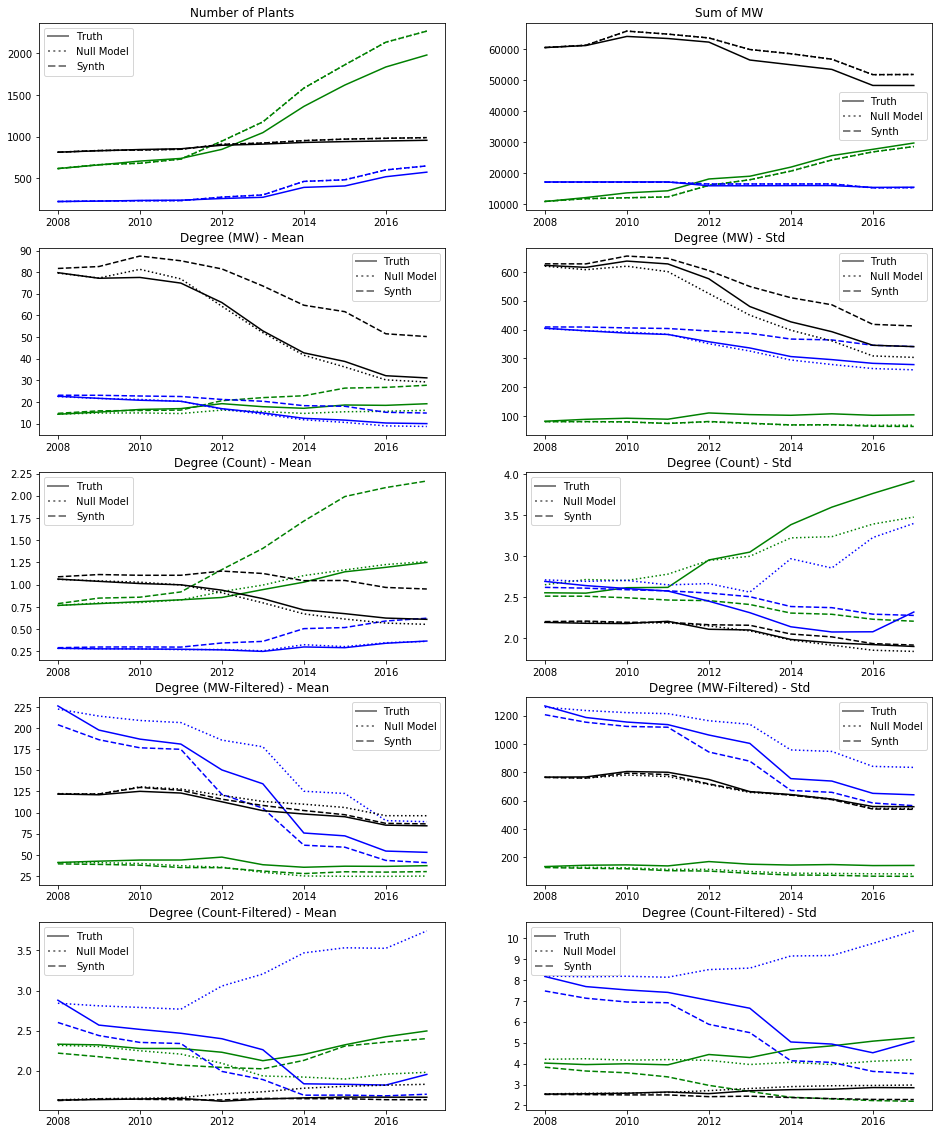

In [97]:
### COMPARE SYTHETIC DFS and INITIAL SLICES

def get_stats(df):
    genned_stats = {
        'n_companies': [len(df[y].COMPANY.unique()) for y in years[1:]],
        'n_plants': [(len(df[y])) for y in years[1:]],
        'n_green': [(df[y].green_MW>0.0).sum() for y in years[1:]],
        'n_blue':[(df[y].blue_MW>0.0).sum() for y in years[1:]],
        'n_ff':[(df[y].ff_MW>0.0).sum() for y in years[1:]],
        'MW_total':[df[y].MW.sum() for y in years[1:]],
        'MW_green':[df[y].green_MW.sum() for y in years[1:]],
        'MW_blue':[df[y].blue_MW.sum() for y in years[1:]],
        'MW_ff':[df[y].ff_MW.sum() for y in years[1:]],
        'mean_green_MW':[df[y].groupby('COMPANY').sum().green_MW.mean() for y in years[1:]],
        'mean_blue_MW':[df[y].groupby('COMPANY').sum().blue_MW.mean()  for y in years[1:]],
        'mean_ff_MW':[df[y].groupby('COMPANY').sum().ff_MW.mean()  for y in years[1:]],
        'std_green_MW':[df[y].groupby('COMPANY').sum().green_MW.std()  for y in years[1:]],
        'std_blue_MW':[df[y].groupby('COMPANY').sum().blue_MW.std() for y in years[1:]],
        'std_ff_MW':[df[y].groupby('COMPANY').sum().ff_MW.std() for y in years[1:]],
        'mean_green_count':[df[y].groupby('COMPANY').sum().green.mean() for y in years[1:]],
        'mean_blue_count':[df[y].groupby('COMPANY').sum().blue.mean()  for y in years[1:]],
        'mean_ff_count':[df[y].groupby('COMPANY').sum().ff.mean()  for y in years[1:]],
        'std_green_count':[df[y].groupby('COMPANY').sum().green.std()  for y in years[1:]],
        'std_blue_count':[df[y].groupby('COMPANY').sum().blue.std() for y in years[1:]],
        'std_ff_count':[df[y].groupby('COMPANY').sum().ff.std() for y in years[1:]],
        
        'mean_green_MW_f':[df[y].groupby('COMPANY').filter(lambda x: x.green_MW.sum()>10**-4.).groupby('COMPANY').sum().green_MW.mean() for y in years[1:]],
        'mean_blue_MW_f':[df[y].groupby('COMPANY').filter(lambda x: x.blue_MW.sum()>10**-4.).groupby('COMPANY').sum().blue_MW.mean()  for y in years[1:]],
        'mean_ff_MW_f':[df[y].groupby('COMPANY').filter(lambda x: x.ff_MW.sum()>10**-4.).groupby('COMPANY').sum().ff_MW.mean()  for y in years[1:]],
        'std_green_MW_f':[df[y].groupby('COMPANY').filter(lambda x: x.green_MW.sum()>10**-4.).groupby('COMPANY').sum().green_MW.std()  for y in years[1:]],
        'std_blue_MW_f':[df[y].groupby('COMPANY').filter(lambda x: x.blue_MW.sum()>10**-4.).groupby('COMPANY').sum().blue_MW.std() for y in years[1:]],
        'std_ff_MW_f':[df[y].groupby('COMPANY').filter(lambda x: x.ff_MW.sum()>10**-4.).groupby('COMPANY').sum().ff_MW.std() for y in years[1:]],
        'mean_green_count_f':[df[y].groupby('COMPANY').filter(lambda x: x.green.sum()>10**-4.).groupby('COMPANY').sum().green.mean() for y in years[1:]],
        'mean_blue_count_f':[df[y].groupby('COMPANY').filter(lambda x: x.blue.sum()>10**-4.).groupby('COMPANY').sum().blue.mean()  for y in years[1:]],
        'mean_ff_count_f':[df[y].groupby('COMPANY').filter(lambda x: x.ff.sum()>10**-4.).groupby('COMPANY').sum().ff.mean()  for y in years[1:]],
        'std_green_count_f':[df[y].groupby('COMPANY').filter(lambda x: x.green.sum()>10**-4.).groupby('COMPANY').sum().green.std()  for y in years[1:]],
        'std_blue_count_f':[df[y].groupby('COMPANY').filter(lambda x: x.blue.sum()>10**-4.).groupby('COMPANY').sum().blue.std() for y in years[1:]],
        'std_ff_count_f':[df[y].groupby('COMPANY').filter(lambda x: x.ff.sum()>10**-4.).groupby('COMPANY').sum().ff.std() for y in years[1:]],
        }
    

    return genned_stats


synth_stats = get_stats(synthetic_df)
truth_stats = get_stats(iso_slice_plants)
null_1_stats = get_stats(null_df)



custom_lines = [Line2D([0], [0], color='gray', lw=2, linestyle='-'),
                Line2D([0], [0], color='gray', lw=2, linestyle=':'),
                Line2D([0], [0], color='gray', lw=2, linestyle='--')]

fig, axs = plt.subplots(5,2,figsize=(16,20))
for ci,cj,ck in zip(['n_green','n_blue','n_ff'],['MW_green','MW_blue','MW_ff'],['green','blue','black']):
    axs[0,0].plot(years[1:],truth_stats[ci], color=ck, linestyle='-')
    axs[0,0].plot(years[1:],synth_stats[ci], color=ck, linestyle='--')
    axs[0,0].plot(years[1:],null_1_stats[ci], color=ck, linestyle=':')

    axs[0,1].plot(years[1:],truth_stats[cj], color=ck, linestyle='-')
    axs[0,1].plot(years[1:],synth_stats[cj], color=ck, linestyle='--')
    axs[0,1].plot(years[1:],null_1_stats[cj], color=ck, linestyle=':')
    
for ci,cj,ck in zip(['mean_green_MW','mean_blue_MW','mean_ff_MW'],['std_green_MW','std_blue_MW','std_ff_MW'],['green','blue','black']):
    axs[1,0].plot(years[1:],truth_stats[ci], color=ck, linestyle='-')
    axs[1,0].plot(years[1:],synth_stats[ci], color=ck, linestyle='--')
    axs[1,0].plot(years[1:],null_1_stats[ci], color=ck, linestyle=':')

    axs[1,1].plot(years[1:],truth_stats[cj], color=ck, linestyle='-')
    axs[1,1].plot(years[1:],synth_stats[cj], color=ck, linestyle='--')
    axs[1,1].plot(years[1:],null_1_stats[cj], color=ck, linestyle=':')
    
for ci,cj,ck in zip(['mean_green_count','mean_blue_count','mean_ff_count'],['std_green_count','std_blue_count','std_ff_count'],['green','blue','black']):
    axs[2,0].plot(years[1:],truth_stats[ci], color=ck, linestyle='-')
    axs[2,0].plot(years[1:],synth_stats[ci], color=ck, linestyle='--')
    axs[2,0].plot(years[1:],null_1_stats[ci], color=ck, linestyle=':')

    axs[2,1].plot(years[1:],truth_stats[cj], color=ck, linestyle='-')
    axs[2,1].plot(years[1:],synth_stats[cj], color=ck, linestyle='--')
    axs[2,1].plot(years[1:],null_1_stats[cj], color=ck, linestyle=':')
    
for ci,cj,ck in zip(['mean_green_MW_f','mean_blue_MW_f','mean_ff_MW_f'],['std_green_MW_f','std_blue_MW_f','std_ff_MW_f'],['green','blue','black']):
    axs[3,0].plot(years[1:],truth_stats[ci], color=ck, linestyle='-')
    axs[3,0].plot(years[1:],synth_stats[ci], color=ck, linestyle='--')
    axs[3,0].plot(years[1:],null_1_stats[ci], color=ck, linestyle=':')

    axs[3,1].plot(years[1:],truth_stats[cj], color=ck, linestyle='-')
    axs[3,1].plot(years[1:],synth_stats[cj], color=ck, linestyle='--')
    axs[3,1].plot(years[1:],null_1_stats[cj], color=ck, linestyle=':')
    
for ci,cj,ck in zip(['mean_green_count_f','mean_blue_count_f','mean_ff_count_f'],['std_green_count_f','std_blue_count_f','std_ff_count_f'],['green','blue','black']):
    axs[4,0].plot(years[1:],truth_stats[ci], color=ck, linestyle='-')
    axs[4,0].plot(years[1:],synth_stats[ci], color=ck, linestyle='--')
    axs[4,0].plot(years[1:],null_1_stats[ci], color=ck, linestyle=':')

    axs[4,1].plot(years[1:],truth_stats[cj], color=ck, linestyle='-')
    axs[4,1].plot(years[1:],synth_stats[cj], color=ck, linestyle='--')
    axs[4,1].plot(years[1:],null_1_stats[cj], color=ck, linestyle=':')

for ii in range(5):
    for jj in range(2):
        axs[ii,jj].legend(custom_lines, ['Truth', 'Null Model','Synth'])
axs[0,0].set_title('Number of Plants')
axs[0,1].set_title('Sum of MW')
axs[1,0].set_title('Degree (MW) - Mean')
axs[1,1].set_title('Degree (MW) - Std')
axs[2,0].set_title('Degree (Count) - Mean')
axs[2,1].set_title('Degree (Count) - Std')
axs[3,0].set_title('Degree (MW-Filtered) - Mean')
axs[3,1].set_title('Degree (MW-Filtered) - Std')
axs[4,0].set_title('Degree (Count-Filtered) - Mean')
axs[4,1].set_title('Degree (Count-Filtered) - Std')

plt.show()


{'blue': [0.9013157894736842, 0.8916876574307304, 0.8900966183574879, 0.8891509433962264, 0.8890063424947146, 0.8898225957049486, 0.8372093023255813, 0.8410404624277457, 0.8128732581287326, 0.8128617363344052], 'green': [0.6710526315789473, 0.6612090680100755, 0.644927536231884, 0.6356132075471699, 0.6162790697674418, 0.5555555555555556, 0.5333333333333333, 0.5072254335260116, 0.5069674850696748, 0.4990353697749196], 'ff': [0.35, 0.36775818639798485, 0.38526570048309183, 0.39740566037735847, 0.42071881606765327, 0.4883286647992531, 0.5697674418604651, 0.596820809248555, 0.6264100862641009, 0.6347266881028939]}
{'blue': [0.8881401617250674, 0.8775235531628534, 0.8726790450928382, 0.8727034120734908, 0.8273657289002557, 0.8085889570552147, 0.7019867549668874, 0.6948968512486428, 0.6494538232373386, 0.6353965183752418], 'green': [0.6455525606469003, 0.6096904441453567, 0.5954907161803713, 0.5564304461942258, 0.42710997442455245, 0.3042944785276074, 0.19426048565121412, 0.1368078175895765,

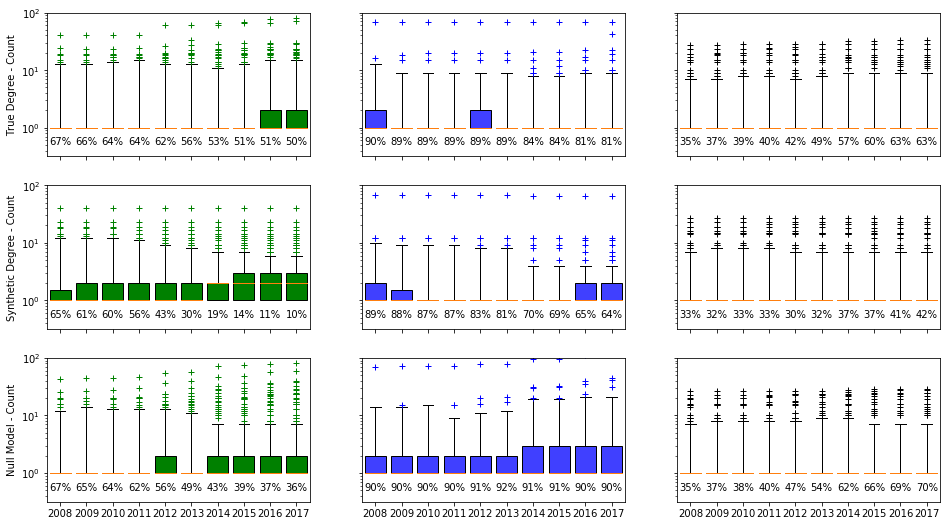

In [98]:
### PLOT DEGREE DISTS WITH BOX & WHISK - COUNT

fig, axs = plt.subplots(3,3,figsize=(16,9), sharey=True, sharex=True)

data_true = {}
data_synth = {}
data_null = {}

N_t = {}
N_s = {}
N_n = {}

for c in ['green', 'blue','ff']:
    data_true[c] = []
    data_synth[c] = []
    data_null[c] = []
    for y in years[1:]:
        df_t = iso_slice_plants[y][['COMPANY',c]].groupby('COMPANY').sum()
        df_s = synthetic_df[y][['COMPANY',c]].groupby('COMPANY').sum()
        df_n = null_df[y][['COMPANY',c]].groupby('COMPANY').sum()
        data_true[c].append(df_t[df_t[c]>10**-4][c].values)
        data_synth[c].append(df_s[df_s[c]>10**-4][c].values)
        data_null[c].append(df_n[df_n[c]>10**-4][c].values)  #companies with positive counts for those assets
    #data_true[c] = [iso_slice_plants[y][['COMPANY',c]].groupby('COMPANY').sum()[c].values for y in years[1:]]
    #data_synth[c] = [synthetic_df[y][['COMPANY',c]].groupby('COMPANY').sum()[c].values for y in years[1:]]
#MW_data = MW_data.sort_values('MW').MW.values
#print MW_data

for c in ['green', 'blue','ff']:
    #%companies that have that don't have that color asset
    N_t[c] = [(1.0 - (float(ii)/jj)) for ii,jj in zip([len(qq) for qq in data_true[c]],[len(iso_slice_plants[y][['COMPANY',c]].groupby('COMPANY').sum()) for y in years[1:]])]
    N_s[c] = [(1.0 - (float(ii)/jj)) for ii,jj in zip([len(qq) for qq in data_synth[c]],[len(synthetic_df[y][['COMPANY',c]].groupby('COMPANY').sum()) for y in years[1:]])]
    N_n[c] = [(1.0 - (float(ii)/jj)) for ii,jj in zip([len(qq) for qq in data_null[c]],[len(null_df[y][['COMPANY',c]].groupby('COMPANY').sum()) for y in years[1:]])]

print N_t
print N_s
print N_n


t_patches = {}
s_patches = {}
n_patches = {}

t_patches['green'] = axs[0,0].boxplot(data_true['green'],0,'g+', whis=[2.5,97.5], patch_artist=True, widths=0.8)
t_patches['blue'] = axs[0,1].boxplot(data_true['blue'],0,'b+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
t_patches['black'] = axs[0,2].boxplot(data_true['ff'],0,'k+', whis=[2.5,97.5], patch_artist=True, widths=0.8)
axs[0,0].set_yscale("log", nonposy='clip')
axs[0,0].set_ylim(bottom=10**-0.5, top=10**2)
axs[0,0].set_ylabel('True Degree - Count')

#axs[2,1].set_xticklabels([str(y) for y in years[1:]])
#axs[2,2].set_xticklabels([str(y) for y in years[1:]])
s_patches['green'] = axs[1,0].boxplot(data_synth['green'],0,'g+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
s_patches['blue'] = axs[1,1].boxplot(data_synth['blue'],0,'b+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
s_patches['black'] = axs[1,2].boxplot(data_synth['ff'],0,'k+', whis=[2.5,97.5], patch_artist=True, widths=0.8)
axs[1,0].set_ylabel('Synthetic Degree - Count')
n_patches['green'] = axs[2,0].boxplot(data_null['green'],0,'g+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
n_patches['blue'] = axs[2,1].boxplot(data_null['blue'],0,'b+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
n_patches['black'] = axs[2,2].boxplot(data_null['ff'],0,'k+', whis=[2.5,97.5], patch_artist=True, widths=0.8)
axs[2,0].set_ylabel('Null Model - Count')

colors = ['green', 'blue', 'black']
cols_dict = {
    'green':'#008000',
    'blue':'#4040ff',
    'black':'#404040',
}
for c in colors:
    for patch in t_patches[c]['boxes']:
        patch.set_facecolor(cols_dict[c])
        
    for patch in s_patches[c]['boxes']:
        patch.set_facecolor(cols_dict[c])
        
    for patch in n_patches[c]['boxes']:
        patch.set_facecolor(cols_dict[c])
        
for ia,c in enumerate(['green', 'blue','ff']):
    for iy in range(len(years)-1):
        axs[0,ia].text(iy+1,10**-0.3,"{0:.0%}".format(N_t[c][iy]), ha='center')
        axs[1,ia].text(iy+1,10**-0.3,"{0:.0%}".format(N_s[c][iy]), ha='center')
        axs[2,ia].text(iy+1,10**-0.3,"{0:.0%}".format(N_n[c][iy]), ha='center')

        
axs[2,0].set_xticklabels([str(y) for y in years[1:]])
        
        
#axs[1,0].set_yscale("log", nonposy='clip')
#axs[1].set_ylim(bottom=10**-3, top=10**4)

plt.savefig('./figures/growth_model/DD_count_n1b2-log10-eps.png')
plt.show()


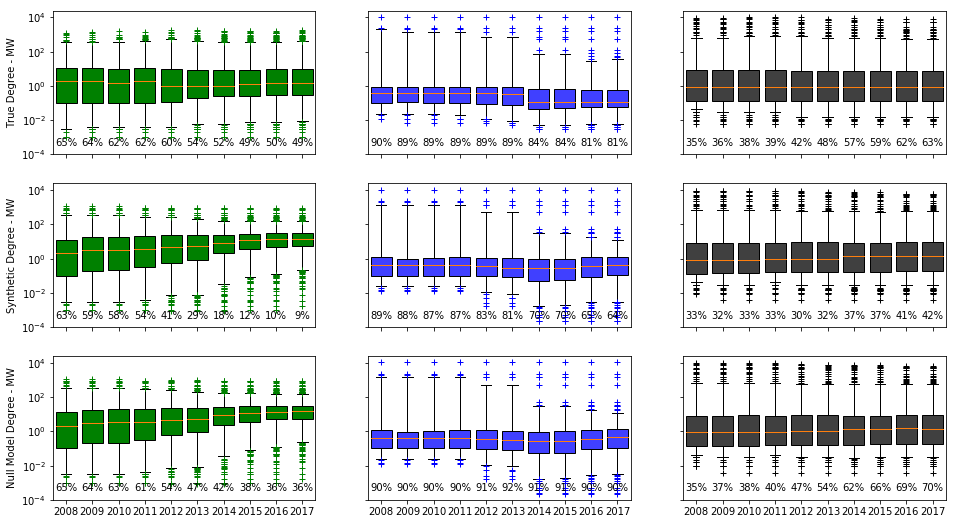

In [99]:
### PLOT DEGREE DISTS WITH BOX & WHISK - MW

fig, axs = plt.subplots(3,3,figsize=(16,9), sharey=True, sharex=True)

data_true = {}
data_synth = {}
data_null = {}

N_t = {}
N_s = {}
N_n = {}

for c in ['green_MW', 'blue_MW','ff_MW']:
    data_true[c] = []
    data_synth[c] = []
    data_null[c] = []
    for y in years[1:]:
        df_t = iso_slice_plants[y][['COMPANY',c]].groupby('COMPANY').sum()
        df_s = synthetic_df[y][['COMPANY',c]].groupby('COMPANY').sum()
        df_n = null_df[y][['COMPANY',c]].groupby('COMPANY').sum()
        data_true[c].append(df_t[df_t[c]>10**-4][c].values)
        data_synth[c].append(df_s[df_s[c]>10**-4][c].values)
        data_null[c].append(df_n[df_n[c]>10**-4][c].values)
    #data_true[c] = [iso_slice_plants[y][['COMPANY',c]].groupby('COMPANY').sum()[c].values for y in years[1:]]
    #data_synth[c] = [synthetic_df[y][['COMPANY',c]].groupby('COMPANY').sum()[c].values for y in years[1:]]
#MW_data = MW_data.sort_values('MW').MW.values
#print MW_data

for c in ['green_MW', 'blue_MW','ff_MW']:
    #% of companies that don't have that color MW
    N_t[c] = [(1.0 - (float(ii)/jj)) for ii,jj in zip([len(qq) for qq in data_true[c]],[len(iso_slice_plants[y][['COMPANY',c]].groupby('COMPANY').sum()) for y in years[1:]])]
    N_s[c] = [(1.0 - (float(ii)/jj)) for ii,jj in zip([len(qq) for qq in data_synth[c]],[len(synthetic_df[y][['COMPANY',c]].groupby('COMPANY').sum()) for y in years[1:]])]
    N_n[c] = [(1.0 - (float(ii)/jj)) for ii,jj in zip([len(qq) for qq in data_null[c]],[len(null_df[y][['COMPANY',c]].groupby('COMPANY').sum()) for y in years[1:]])]


#data = np.concatenate((spread, center, flier_high, flier_low), 0)

t_patches = {}
s_patches = {}
n_patches = {}

t_patches['green'] = axs[0,0].boxplot(data_true['green_MW'],0,'g+', whis=[2.5,97.5], patch_artist=True, widths=0.8)
t_patches['blue'] = axs[0,1].boxplot(data_true['blue_MW'],0,'b+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
t_patches['black'] = axs[0,2].boxplot(data_true['ff_MW'],0,'k+', whis=[2.5,97.5], patch_artist=True, widths=0.8)
axs[0,0].set_yscale("log", nonposy='clip')
axs[0,0].set_ylim(bottom=10**-4)
axs[0,0].set_ylabel('True Degree - MW')
axs[2,0].set_xticklabels([y for y in years[1:]])
axs[2,1].set_xticklabels([y for y in years[1:]])
axs[2,2].set_xticklabels([y for y in years[1:]])

s_patches['green'] = axs[1,0].boxplot(data_synth['green_MW'],0,'g+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
s_patches['blue'] = axs[1,1].boxplot(data_synth['blue_MW'],0,'b+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
s_patches['black'] = axs[1,2].boxplot(data_synth['ff_MW'],0,'k+', whis=[2.5,97.5], patch_artist=True, widths=0.8)
axs[1,0].set_ylabel('Synthetic Degree - MW')
n_patches['green'] = axs[2,0].boxplot(data_synth['green_MW'],0,'g+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
n_patches['blue'] = axs[2,1].boxplot(data_synth['blue_MW'],0,'b+', whis=[2.5,97.5],patch_artist=True, widths=0.8)
n_patches['black'] = axs[2,2].boxplot(data_synth['ff_MW'],0,'k+', whis=[2.5,97.5], patch_artist=True, widths=0.8)
axs[2,0].set_ylabel('Null Model Degree - MW')


colors = ['green', 'blue', 'black']
cols_dict = {
    'green':'#008000',
    'blue':'#4040ff',
    'black':'#404040',
}
for c in colors:
    for patch in t_patches[c]['boxes']:
        patch.set_facecolor(cols_dict[c])
        
    for patch in s_patches[c]['boxes']:
        patch.set_facecolor(cols_dict[c])
        
    for patch in n_patches[c]['boxes']:
        patch.set_facecolor(cols_dict[c])
        
for ia,c in enumerate(['green_MW', 'blue_MW','ff_MW']):
    for iy in range(len(years)-1):
        axs[0,ia].text(iy+1,10**-3.5,"{0:.0%}".format(N_t[c][iy]), ha='center')
        axs[1,ia].text(iy+1,10**-3.5,"{0:.0%}".format(N_s[c][iy]), ha='center')
        axs[2,ia].text(iy+1,10**-3.5,"{0:.0%}".format(N_n[c][iy]), ha='center')
    
axs[2,2].set_xticklabels([y for y in years[1:]])  
        
#axs[1,0].set_yscale("log", nonposy='clip')
#axs[1].set_ylim(bottom=10**-3, top=10**4)
plt.savefig('./figures/growth_model/DD_MW_n1b2-log10-eps.png')
plt.show()


(15.252034260549262, 0.088362013190074307, 84.659603726260727)
(22.883356530140421, 0.13181241119994686, 76.98483105865958)
(34.717256831237883, 0.55045246078497267, 64.732290707977086)
(12.416062841187234, 0.08128778476046794, 87.502649374052368)
(18.479991316057014, 0.44526473357646379, 81.074743950366525)
(47.449551190248762, 0.24782407207414509, 52.302624737677064)
(15.435919944517501, 0.14420280935947802, 84.41987724612305)
(29.119189390561068, 0.27850401563469046, 70.602306593804244)
(45.551134257014908, 0.41092227575927254, 54.037943467225858)


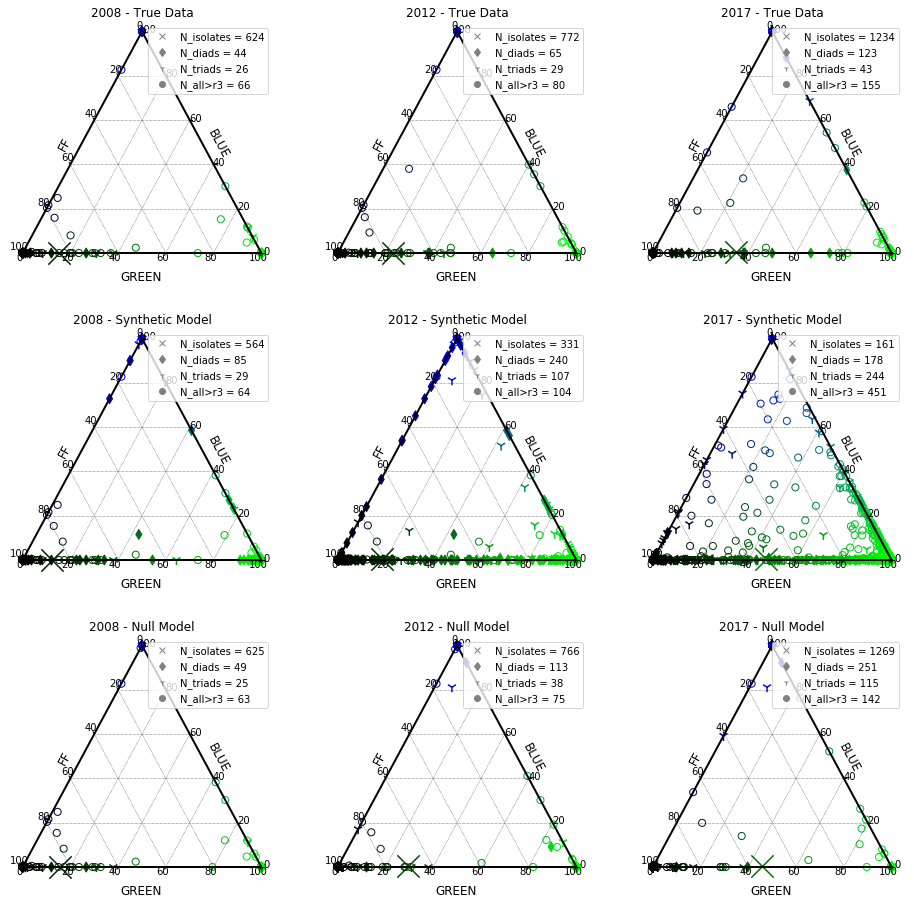

In [100]:
### DRAW TERNARY - ISOLATES - mean MW., DIADS; TRIADS; TOP 10 x 2 - count, MW, with lines for years
fig,axs = plt.subplots(3,3,figsize=(16,16))
model_dict = {
    0:'True Data',
    1:'Synthetic Model',
    2:'Null Model'
}


for ii,df in enumerate([iso_slice_plants, synthetic_df, null_df]):
    for jj,y in enumerate([2008,2012,2017]):
        axs[ii,jj].axis('off')
        tfig, tax = ternary.figure(ax=axs[ii,jj], scale=100.0)

        tax.boundary(linewidth=2.0)
        tax.gridlines(color='black', multiple=20)
        # Remove default Matplotlib Axes
        tax.clear_matplotlib_ticks()
        tax.set_title(str(y)+ ' - '+model_dict[ii], fontsize=12)
        tax.left_axis_label("FF", fontsize=12)
        tax.right_axis_label("BLUE", fontsize=12)
        tax.bottom_axis_label("GREEN", fontsize=12)

        tax.ticks(axis='lbr', multiple=20, linewidth=1)
        
        df_t = (df[y][['COMPANY','MW','green_MW', 'blue_MW','ff_MW']]
                .groupby('COMPANY').filter(lambda x: x['MW'].count()==1)
                .groupby('COMPANY').sum())
        n_isolates = len(df_t)
        
        ISOLATES_MEAN = (
            (df_t.mean().green_MW / df_t.mean().MW *100.0),
            (df_t.mean().blue_MW / df_t.mean().MW *100.0),
            (df_t.mean().ff_MW / df_t.mean().MW *100.0))
        g = int(ISOLATES_MEAN[0]/100.*255)
        b = int(ISOLATES_MEAN[1]/100.*255)
            
        print ISOLATES_MEAN
        tax.scatter([ISOLATES_MEAN], marker='x', s=500, color="#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)))#, label='Isolates Mean (N='+str(n_isolates)+')')
            
        DIADS = (df[y][['COMPANY','MW','green_MW', 'blue_MW','ff_MW']]
                .groupby('COMPANY').filter(lambda x: x['MW'].count()==2)
                .groupby('COMPANY').sum())
        DIADS['green_norm'] = DIADS.green_MW / DIADS.MW *100.0
        DIADS['blue_norm'] = DIADS.blue_MW / DIADS.MW * 100.0
        DIADS['ff_norm'] = DIADS.ff_MW / DIADS.MW * 100.0
        
        DIADS = DIADS.as_matrix(columns=['green_norm','blue_norm','ff_norm'])
        
        color_diads = []
        for ci in range(DIADS.shape[0]):
            g = int(DIADS[ci,0]/100.*255)
            b = int(DIADS[ci,1]/100.*255)
            color_diads.append("#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)))
        n_diads = len(color_diads)
        
        #print DIADS
        tax.scatter(DIADS, marker='d', s=50, color=color_diads)#, label='Diads (N='+str(len(color_diads))+')')
        
        
        TRIADS = (df[y][['COMPANY','MW','green_MW', 'blue_MW','ff_MW']]
                .groupby('COMPANY').filter(lambda x: x['MW'].count()==3)
                .groupby('COMPANY').sum())
        TRIADS['green_norm'] = TRIADS.green_MW / TRIADS.MW *100.0
        TRIADS['blue_norm'] = TRIADS.blue_MW / TRIADS.MW * 100.0
        TRIADS['ff_norm'] = TRIADS.ff_MW / TRIADS.MW * 100.0
        
        TRIADS = TRIADS.as_matrix(columns=['green_norm','blue_norm','ff_norm'])
        
        color_triads = []
        for ci in range(TRIADS.shape[0]):
            g = int(TRIADS[ci,0]/100.*255)
            b = int(TRIADS[ci,1]/100.*255)
            color_triads.append("#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)))
        n_triads = len(color_triads)
        
        #print DIADS
        tax.scatter(TRIADS, marker='1', s=100, color=color_triads)#, label='Triads (N='+str(len(color_triads))+')')
        
        
        ALL = (df[y][['COMPANY','MW','green_MW', 'blue_MW','ff_MW']]
                .groupby('COMPANY').filter(lambda x: x['MW'].count()>3)
                .groupby('COMPANY').sum())
        
        #print ALL
        ALL['green_norm'] = ALL.green_MW / ALL.MW *100.0
        ALL['blue_norm'] = ALL.blue_MW / ALL.MW * 100.0
        ALL['ff_norm'] = ALL.ff_MW / ALL.MW * 100.0
        
        s_all = ALL.as_matrix(columns=['MW'])
        
        ALL = ALL.as_matrix(columns=['green_norm','blue_norm','ff_norm'])
        
        #print s_all
        
        color_all = []
        for ci in range(ALL.shape[0]):
            g = int(ALL[ci,0]/100.*255)
            b = int(ALL[ci,1]/100.*255)
            color_all.append("#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)))
            
        n_all = len(color_all)
        
        #print DIADS
        
        tax.scatter(ALL, marker='o', s=50, edgecolors=color_all, facecolors='None')#, markeredgewidth=1,markerfacecolor='None')#, label='All others (N='+str(len(color_all))+')')
        
        custom_markers = [Line2D([0], [0], color='gray', marker='x', lw=0,linestyle=None),
                Line2D([0], [0], color='gray', lw=0,marker='d'),
                Line2D([0], [0], color='gray', lw=0,marker='1'),
                Line2D([0], [0], color='gray', lw=0,marker='o'),]
        
        labels = [
            'N_isolates = '+str(n_isolates),
            'N_diads = '+str(n_diads),
            'N_triads = '+str(n_triads),
            'N_all>r3 = '+str(n_all),
        ]
        
        
        
        tax.legend(custom_markers, labels, loc='upper right')
        
plt.show()

In [11]:
print wepp_slice_plants.loc[wepp_slice_plants['COMPANY']=='3C WASTE LTD']

                        COMPANY fuel_class    YEAR  green   blue  solar  \
PLANT                                                                     
STANDARD LANDFILL  3C WASTE LTD      WASTE  1996.0   True  False  False   

                    wind     ff     MW  CCCE  green_MW  blue_MW  solar_MW  \
PLANT                                                                       
STANDARD LANDFILL  False  False  0.875   NaN     0.875      0.0       0.0   

                   wind_MW  ff_MW  
PLANT                              
STANDARD LANDFILL      0.0    0.0  


In [11]:
### TAKE NEW ASSETS AND MAKE SYNTHETIC DFS

print x_cols

plant_ii = 0
company_ii = 0

synthetic_df = {}
synthetic_df[years[0]] = iso_slice_plants[years[0]]

#for n in new_assets[2008]:
#    print n

for y in years[1:]:
    
    print y
    synthetic_df[y] = copy.deepcopy(synthetic_df[y-1])
    
    #drop retired plants
    synthetic_df[y] = synthetic_df[y][~synthetic_df[y].index.isin(retired_plants[y])]
    
    cols = list(synthetic_df[y-1])

    
    
    
    ### generate array of input data
    

    
    ###Ex-post for the regressor
    x = synthetic_df[y-1][['COMPANY','MW']].groupby('COMPANY').count()
    x = x.rename(columns={'MW':'n_plants'})
    for c in ['green','blue','ff','green_MW','blue_MW','ff_MW','MW']:
        x[c] = synthetic_df[y-1][['COMPANY',c]].groupby('COMPANY').sum().astype(float)
        
            
    for c in ['green','blue','ff']:
        x['n%_'+c] = x[c]/x['n_plants'].astype(float)
        x['MW%_'+c] = x[c.split('_')[0]+'_MW']/x['MW'].astype(float)
        
        
    #print 'interim x', list(x)
    #x = pd.concat([x,pd.DataFrame({
    x = x.append(pd.DataFrame({
        'n_plants':0.0, 
        'green':0.0, 
        'blue':0.0, 
        'ff':0.0, 
        'green_MW':0.0, 
        'blue_MW':0.0, 
        'ff_MW':0.0, 
        'MW':0.0, 
        'n%_green':0.0, 
        'MW%_green':0.0, 
        'n%_blue':0.0, 
        'MW%_blue':0.0, 
        'n%_ff':0.0, 
        'MW%_ff':0.0,
    }, index=['DUMMY_NEW_CO']))
    #print x
        
    
    for n in new_assets[y]:
        print n
        
        x['add_MW'] = n['MW']
        x['add_green%'] = 0.0
        x['add_blue%'] = 0.0
        x['add_ff%'] = 0.0
        if n['color']=='g':
            x['add_green%'] = 1.0
        elif n['color']=='b':
            x['add_blue%'] = 1.0
        elif n['color']=='ff':
            x['add_ff%'] = 1.0
        
        ## cross features
        for c_i in ['n_plants', 'green', 'blue', 'ff', 'green_MW', 'blue_MW', 'ff_MW', 'MW', 'n%_green', 'MW%_green', 'n%_blue', 'MW%_blue', 'n%_ff', 'MW%_ff']:
            for c_o in ['add_MW', 'add_green%', 'add_blue%', 'add_ff%']:
                x[str(c_i)+'_x_'+str(c_o)] = x[c_i]*x[c_o]
                
        x = x[x_cols]
        
        if not list(x)==x_cols:
            print 'list header mismatch'
            break
        
        #print len(list(x))
        #print len(x_cols)
        
        X_predict = x.as_matrix(columns=x_cols)
        
        prediction = logreg[y].predict_proba(X_predict)[:,1]
        ii = np.random.choice(range(len(prediction)),p=prediction/np.sum(prediction))
        #print ii
        print x.iloc[ii].name
        #print dir(x.iloc[ii].name)
        
        if x.iloc[ii].name == 'DUMMY_NEW_CO':
            name = 'NEW_COMPANY_'+str(company_ii)
            company_ii+=1
        else:
            name = x.iloc[ii].name
        
        #print cols
        color_dict = {}
        color_dict['name'] = {
             'g':'green',
             'b':'blue',
             'f':'ff'
         }
        color_dict['color_arr'] = {
            'g':[1.0,0.0,0.0],
            'b':[0.0,1.0,0.0],
            'f':[0.0,0.0,1.0],
        }
        
        synthetic_df[y] = synthetic_df[y].append(pd.DataFrame({
            'COMPANY':name, 
            'fuel_class':'N/A_GEN', 
            'YEAR':y, 
            'green':color_dict['color_arr'][n['color']][0], 
            'blue':color_dict['color_arr'][n['color']][1], 
            'solar':0.0, 
            'wind':0.0, 
            'ff':color_dict['color_arr'][n['color']][2], 
            'MW':n['MW'], 
            'CCCE':0.0, 
            'green_MW':color_dict['color_arr'][n['color']][0]*n['MW'], 
            'blue_MW':color_dict['color_arr'][n['color']][1]*n['MW'], 
            'solar_MW':0.0, 
            'wind_MW':0.0, 
            'ff_MW':color_dict['color_arr'][n['color']][2]*n['MW'],
        }, index=['NEW_PLANT_'+str(plant_ii)]))
            
        plant_ii+=1
        
    for p in extra_plants[y]:
        synthetic_df[y] = synthetic_df[y].append(iso_slice_plants[y].ix[p])
    
    

['n_plants', 'green', 'blue', 'ff', 'green_MW', 'blue_MW', 'ff_MW', 'MW', 'n%_green', 'MW%_green', 'n%_blue', 'MW%_blue', 'n%_ff', 'MW%_ff', 'add_MW', 'add_green%', 'add_blue%', 'add_ff%', 'n_plants_x_add_MW', 'n_plants_x_add_green%', 'n_plants_x_add_blue%', 'n_plants_x_add_ff%', 'green_x_add_MW', 'green_x_add_green%', 'green_x_add_blue%', 'green_x_add_ff%', 'blue_x_add_MW', 'blue_x_add_green%', 'blue_x_add_blue%', 'blue_x_add_ff%', 'ff_x_add_MW', 'ff_x_add_green%', 'ff_x_add_blue%', 'ff_x_add_ff%', 'green_MW_x_add_MW', 'green_MW_x_add_green%', 'green_MW_x_add_blue%', 'green_MW_x_add_ff%', 'blue_MW_x_add_MW', 'blue_MW_x_add_green%', 'blue_MW_x_add_blue%', 'blue_MW_x_add_ff%', 'ff_MW_x_add_MW', 'ff_MW_x_add_green%', 'ff_MW_x_add_blue%', 'ff_MW_x_add_ff%', 'MW_x_add_MW', 'MW_x_add_green%', 'MW_x_add_blue%', 'MW_x_add_ff%', 'n%_green_x_add_MW', 'n%_green_x_add_green%', 'n%_green_x_add_blue%', 'n%_green_x_add_ff%', 'MW%_green_x_add_MW', 'MW%_green_x_add_green%', 'MW%_green_x_add_blue%', 'M

WAKEFIELD HOSPITAL
{'color': 'g', 'MW': 0.67126834879182007}
STAKIS PLC
{'color': 'g', 'MW': 0.96742207951230252}
HAVERFORDWERT HOSPITAL
{'color': 'f', 'MW': 0.072058125109049964}
OPTIC TECHNIUM
{'color': 'f', 'MW': 0.17207677010296554}
METEOROLOGICAL OFFICE
{'color': 'f', 'MW': 498.70963444068673}
ROSLIN INSTITUTE
{'color': 'f', 'MW': 0.19576828672957353}
ST BARTS HOSPITAL
{'color': 'g', 'MW': 0.98649119408311803}
BRITISH TISSUES (BRIDGEND) LTD
{'color': 'g', 'MW': 2.2097782148394463}
CHELTENHAM & GLOUCESTER M H
{'color': 'f', 'MW': 47.341978713172011}
MILLENNIUM DOME
{'color': 'g', 'MW': 3.5174508205614377}
FG WILSON ENGINEERING LTD
{'color': 'f', 'MW': 69.665771121193785}
LUTON BOROUGH COUNCIL
2010
{'color': 'g', 'MW': 4.6979353313533769}
ENERGYTECH LTD
{'color': 'g', 'MW': 47.832798961470175}
AGRILEC LTD
{'color': 'g', 'MW': 1.5586390150009246}
ROTHERHAM HOSPITAL
{'color': 'g', 'MW': 5.7683138075402747}
CHEPSTOW SCHOOL
{'color': 'g', 'MW': 8.8854701400311082}
BEDFORD HOSPITAL
{'col

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


PURFLEET BOARD MILLS
{'color': 'g', 'MW': 22.96899851258592}
SOUTHWEST GAS BOARD
{'color': 'g', 'MW': 20.227377195098001}
WELSH DEVELOPMENT AGENCY (WDA)
{'color': 'g', 'MW': 0.55473591651536303}
PRINCESS ROYAL HOSPITAL
{'color': 'f', 'MW': 32.482361747240347}
TEGWYN JONES
{'color': 'b', 'MW': 1.3157073466142739}
BROUGHTON LAYS
{'color': 'g', 'MW': 0.0030333437515946524}
NEWCASTLE CIVIC CENTRE
{'color': 'f', 'MW': 109.68343167048255}
DUMMY_NEW_CO
{'color': 'b', 'MW': 2.5772994207818281}
ILKESTON CONSUMER CO-OP SOC
{'color': 'f', 'MW': 1247.806100789026}
DRAX POWER LTD
{'color': 'g', 'MW': 84.851359960359048}
DUMMY_NEW_CO
{'color': 'g', 'MW': 42.065561016178336}
WIGTON WIND PLANT
{'color': 'f', 'MW': 69.005779098597614}
DUMMY_NEW_CO
{'color': 'f', 'MW': 3205.7214527167698}
INTERGEN (UK) LTD
2011
{'color': 'g', 'MW': 3.794546883586468}
LEWISHAM HOSPITAL
{'color': 'g', 'MW': 78.273422532543648}
NANT FARM
{'color': 'g', 'MW': 2.5953820068119597}
SMITH STONE KNIGHT
{'color': 'g', 'MW': 0.208

{'color': 'g', 'MW': 28.616326967228236}
ROYAL COLLEGE OF SURGEONS
{'color': 'g', 'MW': 9.5242046937353546}
A PEARSON & SONS
{'color': 'g', 'MW': 2.2265766545930599}
SUFFOLK COUNTY COUNCIL
{'color': 'g', 'MW': 112.07415176531445}
RADISSON SAS
{'color': 'g', 'MW': 4.5362039769870952}
BRITISH SALT LTD
{'color': 'f', 'MW': 5.9702207722714211e-06}
HUW SMALLWOOD
{'color': 'g', 'MW': 29.410933269395947}
ST BARTS HOSPITAL
{'color': 'g', 'MW': 0.18571858318061713}
MILTON KEYNES POLICE
{'color': 'f', 'MW': 69.291341408650879}
OPTIC TECHNIUM
{'color': 'g', 'MW': 0.56877869447300178}
BRITISH SIDAC LTD
{'color': 'g', 'MW': 9.9201103159399207}
BHP BILLITON PETROLEUM
{'color': 'b', 'MW': 0.025041984481666644}
COOKSTOWN
{'color': 'b', 'MW': 1.1637868054663623}
ASHFORD INTL HOTEL
{'color': 'g', 'MW': 6.0593337097161122}
SIR JAMES ALTHAM POOL
{'color': 'b', 'MW': 0.16515583591155991}
CENTURY STEELS LTD
{'color': 'f', 'MW': 28.210241889895606}
MENDIP POWER GROUP
{'color': 'g', 'MW': 813.11064774192459}


WOKING BOUROUGH COUNCIL
{'color': 'g', 'MW': 8.7007640855437831}
NEW_COMPANY_4
{'color': 'g', 'MW': 11.711481561870983}
CONRAD HOTEL
{'color': 'g', 'MW': 55.738871050846726}
TANGMERE AIRFIELD NURSERIES
{'color': 'g', 'MW': 0.012321854612955707}
ATLANTIC ENERGY LTD
{'color': 'g', 'MW': 1.1722626134886582}
BRITISH TELECOM (BT)
{'color': 'g', 'MW': 335.20381150723}
MIDDLESEX HOSPITAL
{'color': 'g', 'MW': 8.602094390341934}
UNIVERSITY OF ULSTER COLERAINE
{'color': 'g', 'MW': 40.431781486015225}
CALEDONIAN HOTEL
{'color': 'g', 'MW': 48.583671304016342}
BECTON DICKINSON AND CO
{'color': 'g', 'MW': 1.2017967266267156}
SHP PROJECTS LTD
{'color': 'g', 'MW': 1.0500879412969255}
THOMAS TAIT & SONS
{'color': 'b', 'MW': 0.011307613054128128}
STRESSHOLME STW
{'color': 'g', 'MW': 3.6847413100707791}
NORTH TYNESIDE HOSPITAL
{'color': 'g', 'MW': 0.079845812798853014}
PETERSFLNGER STW
{'color': 'f', 'MW': 0.00015712219865964138}
PRINCE PHILIP HOSPITAL
{'color': 'g', 'MW': 1.5773872238808482}
DARLINGTON 

{'color': 'g', 'MW': 5.8043155588683568}
INGLEBY 451 LTD
{'color': 'g', 'MW': 14.889854656389296}
THOMAS TAIT & SONS
{'color': 'g', 'MW': 11.72931537793125}
COMMUNITY WINDPOWER LTD
{'color': 'g', 'MW': 0.85492719401395711}
TITANIC QUARTER
{'color': 'f', 'MW': 3.6847383789537873}
JERSEY RESOURCES RECOVERY BD
{'color': 'g', 'MW': 0.4690692277988906}
HUMBERSIDE WASTEWISE WST MGMT
{'color': 'g', 'MW': 0.96385711283658382}
ALTON SPORTS CENTRE
{'color': 'g', 'MW': 9.6104082894023417}
CARDIFF AND VALE NHS TRUST
{'color': 'f', 'MW': 7.9525032844397074}
IMERYS
{'color': 'g', 'MW': 2.487898047371206}
GARDEN HOUSE HOTEL
{'color': 'b', 'MW': 0.043849792981268079}
COFELY UK
{'color': 'g', 'MW': 3.4997944006213277}
WINDCLUSTER LTD
{'color': 'g', 'MW': 0.049499923656418636}
PERTHSHIRE HOUSING ASSOCIATION
{'color': 'g', 'MW': 0.16279094979627512}
LIVERPOOL CORP WATER WORKS
{'color': 'g', 'MW': 0.0058538908144183102}
HEARTHSTANES BURN HYDRO
{'color': 'g', 'MW': 62.107699404729303}
BRADFORD CREST
{'colo

{'color': 'g', 'MW': 10.056411728242781}
TLS HYDRO POWER LTD
{'color': 'g', 'MW': 3.3193899237685871}
BLUE CIRCLE INDUSTRIES
{'color': 'g', 'MW': 5.5928502238642759}
ELEC & MUSICAL INDUST (EMI)
{'color': 'g', 'MW': 0.32354090733284713}
LEIGH ENVIRONMENTAL LTD
{'color': 'g', 'MW': 26.283470908386523}
LARNE LEISURE CENTRE
{'color': 'g', 'MW': 29.133867796709492}
WYVERN WASTE SERVICES LTD
{'color': 'g', 'MW': 0.47671385747823203}
LEEK DYEING
{'color': 'g', 'MW': 4.5802991005228977}
ARCHER DANIELS MIDLAND CORP
{'color': 'g', 'MW': 5.857653242779528}
CONRAD HOTEL
{'color': 'g', 'MW': 2.2628769931477435}
ATLANTIC ENERGY LTD
{'color': 'f', 'MW': 1.087585527023105}
KAPPA SSK LTD
{'color': 'g', 'MW': 27.682394928338443}
BOROUGH OF HAVERING
{'color': 'g', 'MW': 0.025242074487623601}
BRITISH BROADCASTING CORP-BBC
{'color': 'g', 'MW': 3.9556981373661122}
CHEDDON HOSPITAL
{'color': 'f', 'MW': 0.00068324887094982714}
WEST SUFFOLK HOSPITAL
{'color': 'g', 'MW': 3.6090921277466683}
GARBHAIG HYDRO POWER

{'color': 'g', 'MW': 4.5374623066919257}
CHATSWORTH HOUSE
{'color': 'g', 'MW': 9.3992193663330621}
CHATSWORTH HOUSE
{'color': 'b', 'MW': 0.33664077305957102}
KARLSHAMS
{'color': 'b', 'MW': 1.9307653238183895}
LANDFILL MANAGEMENT LTD
{'color': 'b', 'MW': 2.2824196715171641}
POOLBANK SALADS
{'color': 'f', 'MW': 0.15552801427295992}
KILMINGTON STW
{'color': 'b', 'MW': 0.001594265296421801}
REASEHEATH COLLEGE
{'color': 'g', 'MW': 0.77232750130146011}
MEIRIONNYDD FARM
{'color': 'g', 'MW': 11.460120858339071}
HAREFIELD HOSPITAL
{'color': 'g', 'MW': 3.0519110421317683}
MARRIOTT INTERNATIONAL
{'color': 'g', 'MW': 24.474920019436535}
DUMMY_NEW_CO
{'color': 'f', 'MW': 0.054719050262696571}
BLUE CIRCLE INDUSTRIES
{'color': 'b', 'MW': 0.048764390543148121}
GIFFORD STREET APARTMENTS
{'color': 'g', 'MW': 2.5121525747083502}
MYRES HILL TEST SITE
{'color': 'g', 'MW': 9.1761904003175783}
POOLE GENERAL HOSPITAL
{'color': 'g', 'MW': 2.8882178776561571}
HIGH WYCOMBE LEISURE CENTRE
{'color': 'g', 'MW': 0.2

{'color': 'g', 'MW': 4.6820506681435603}
KINGSWAY HOSPITAL
{'color': 'b', 'MW': 0.012958613568077398}
ARTHUR GUINESS SON & CO
{'color': 'g', 'MW': 1.4090399258703949}
REG BIOPOWER
{'color': 'b', 'MW': 3.3557691060243329}
STIRLING WATER
{'color': 'g', 'MW': 14.640191628668122}
DUMMY_NEW_CO
{'color': 'g', 'MW': 29.596963195619264}
DUMMY_NEW_CO
{'color': 'g', 'MW': 3.0383639222453023}
ROYAL BERKSHIRE HOTEL
{'color': 'g', 'MW': 1.7733159280537136}
KILKEEL LESIURE CENTRE
{'color': 'b', 'MW': 0.39323423772031807}
BUSINESS INNOVATION CENTRE
{'color': 'g', 'MW': 22.970471627594776}
DUMMY_NEW_CO
{'color': 'g', 'MW': 3.3448156517728815}
SCOTT STREET
{'color': 'g', 'MW': 2.1385889872732062}
GARBHAIG HYDRO POWER CO LTD
{'color': 'g', 'MW': 0.26718534635352847}
WEISS GROUP
{'color': 'g', 'MW': 9.7330037460000884}
ROYAL LIFE INSURANCE
{'color': 'b', 'MW': 0.16713237803171338}
WOOD GREEN ANIMAL SHELTER
{'color': 'b', 'MW': 0.023089102847984509}
PRINCESS ROYAL HOSPITAL
{'color': 'b', 'MW': 0.083340790

{'color': 'g', 'MW': 1.1695024920010004}
HEARTHSTANES BURN HYDRO
{'color': 'b', 'MW': 8.6478375535824181}
WAKEFIELD POLICE STATION
{'color': 'g', 'MW': 0.57846182473926611}
GREENBANK LEISURE CENTRE
{'color': 'g', 'MW': 26.74535199205631}
DUMMY_NEW_CO
{'color': 'g', 'MW': 2.6375567009898919}
PARAMOUNT HOTELS
{'color': 'b', 'MW': 0.0036596964275466752}
BIOPLEX LTD
{'color': 'g', 'MW': 10.069977230099916}
DRIMSYNIE CONSTRUCTION
{'color': 'g', 'MW': 0.25741351044733141}
TEBBUTT'S FARM
{'color': 'g', 'MW': 0.34104834995056693}
THREE VALLEYS WATER PLC
{'color': 'g', 'MW': 1.2380551308342165}
WYKES ENGINEERING
{'color': 'b', 'MW': 0.0075863816246219459}
SUMMERLANDS HOSPITAL
{'color': 'f', 'MW': 1.166954796927828}
BANK FARM
{'color': 'g', 'MW': 1.3702298471245777}
CHESTER CITY COUNCIL
{'color': 'b', 'MW': 0.018319770669953894}
RAINBOW LEISURE CENTRE
{'color': 'g', 'MW': 0.094726493487323468}
PEDLEY BOILER HOUSE
{'color': 'g', 'MW': 7.1251476485249752}
COVENTRY HILTON
{'color': 'g', 'MW': 23.42

DRIMSYNIE CONSTRUCTION
{'color': 'b', 'MW': 0.14354763002533102}
MONSANTO PLC
{'color': 'b', 'MW': 0.15136320136712547}
PAS (GRANTHAM) LTD
{'color': 'g', 'MW': 0.21562512380158097}
EWG (UK) LTD
{'color': 'g', 'MW': 2.1721689023630697}
KARLSHAMS
{'color': 'g', 'MW': 3.3581933693444608}
ST ERMINS HOTEL
{'color': 'b', 'MW': 0.022992092569883524}
BRUICHLADDICH DISTILLERY
{'color': 'g', 'MW': 0.30722758944154283}
BRACKNELL FOREST BOR COUNCIL
{'color': 'g', 'MW': 0.5629578618888984}
BUYINFO LTD
{'color': 'g', 'MW': 1.1154563598087663}
TEG GROUP PLC
{'color': 'g', 'MW': 15.871155038633887}
ESI
{'color': 'g', 'MW': 16.050357343998549}
SCOTTISH NATURAL HERITAGE
{'color': 'b', 'MW': 0.14927686754355976}
NATIONAL RAILWAY MUSEUM
{'color': 'g', 'MW': 3.3702260311481256}
VIKING HOTEL
{'color': 'b', 'MW': 0.021080288996181015}
LONGLEY FARM
{'color': 'b', 'MW': 4.6971156944773593}
MORAY LEISURE CENTRE
{'color': 'g', 'MW': 6.3269033131193293}
TEG GROUP PLC
{'color': 'g', 'MW': 6.5605279557292784}
HEXHA

LEYLAND VEHICLES LTD
{'color': 'g', 'MW': 13.768495614949986}
BALMORAL ESTATE
{'color': 'g', 'MW': 2.0501328607359763}
DARLINGTON MEMORIAL HOSPITAL
{'color': 'g', 'MW': 10.169068253934336}
HUMBERSIDE WASTEWISE WST MGMT
{'color': 'g', 'MW': 2.990475908597253}
ST DAVIDS COLLEGE
{'color': 'g', 'MW': 7.4005690214631734}
WOODFORD LEISURE CENTRE
{'color': 'b', 'MW': 0.072640692344082991}
NEW_COMPANY_23
{'color': 'g', 'MW': 0.60371539852242495}
SMITH STONE KNIGHT
{'color': 'g', 'MW': 0.6404386376545117}
PEABODY TRUST
{'color': 'g', 'MW': 0.35997467661903421}
WALFORD COLLEGE FARM
{'color': 'g', 'MW': 2.9018242420065441}
CLAIRE PENNY
{'color': 'g', 'MW': 2.5528247363321852}
WINDCLUSTER LTD
{'color': 'g', 'MW': 57.136416377146617}
TULLIS RUSSELL GROUP
{'color': 'f', 'MW': 0.27561474849434314}
CANFORD RENEWABLE ENERGY
{'color': 'g', 'MW': 19.235269764128173}
VIRGIN LIMITED EDITION
{'color': 'g', 'MW': 18.303444006298022}
WALTHAM ABBEY NURSERY
{'color': 'g', 'MW': 24.952668140892765}
LEEDS UNIVERS

NEW_COMPANY_9
{'color': 'g', 'MW': 6.5595552254624323}
FL INGALL
{'color': 'g', 'MW': 0.0030070057579223049}
ROQUETTE FRERES
{'color': 'g', 'MW': 0.88811972663005101}
CRISP MALTINGS
{'color': 'g', 'MW': 7.9620707961374189}
BANHAM POULTRY
{'color': 'g', 'MW': 0.34072405319952781}
NEW_COMPANY_38
{'color': 'g', 'MW': 0.52807289667306168}
KINGFISHER LEISURE CENTRE
{'color': 'b', 'MW': 0.96938939756074594}
HERDMANS LTD
{'color': 'g', 'MW': 0.42101639904708588}
BRANDSHATCH PLACE HOTEL
{'color': 'g', 'MW': 0.11548933341426319}
MILL NURSERIES
{'color': 'g', 'MW': 15.997473712928498}
HAARMAAN & REIMER
{'color': 'g', 'MW': 2.7967362286386561}
SKEGNESS GRAMMAR SCHOOL
{'color': 'f', 'MW': 0.092135081351431891}
HEXHAM GENERAL HOSPITAL
{'color': 'g', 'MW': 1.8018110985937306}
PFIZER LTD
{'color': 'g', 'MW': 9.8500059121282391}
TNEI SERVICES
{'color': 'g', 'MW': 35.056597295835502}
WHITBREAD BREWERY
{'color': 'b', 'MW': 0.083027208316390488}
PLYMOUTH PAVILLIONS
{'color': 'g', 'MW': 2.0463604541350993

HARNEY'S LAW FIRM
{'color': 'g', 'MW': 0.38447831044690955}
QUEEN'S UNIVERSITY BELFAST
{'color': 'g', 'MW': 14.503079608054476}
DUMMY_NEW_CO
{'color': 'g', 'MW': 0.039799586480367369}
MONMOUTH NEW HYDRO SCHEME
{'color': 'b', 'MW': 0.098058560099084979}
STRATHDON HYDRO
{'color': 'g', 'MW': 0.2205543383265535}
THAMESWEY ENERGY
{'color': 'g', 'MW': 2.0700472717477885}
ALVASTON HALL HOTEL
{'color': 'g', 'MW': 9.1060252643661936}
BURGESSHILL LEISURE CENTRE
{'color': 'g', 'MW': 0.32701487668973617}
PERTHSHIRE HOUSING ASSOCIATION
{'color': 'g', 'MW': 0.96486249115994671}
CHALYBEATE HOSPITAL
{'color': 'g', 'MW': 15.240908967736058}
STRANGFORD LOUGH WILDFOWLERS
{'color': 'g', 'MW': 6.1711395705566714}
DURHAM COUNTY WASTE MANAGEMENT
{'color': 'g', 'MW': 2.6856569023821413}
LOWWOOD PRODUCTS CO LTD
{'color': 'f', 'MW': 26.109945630504733}
DUMMY_NEW_CO
{'color': 'g', 'MW': 5.4586177147905328}
WEST WALES GENERAL HOSPITAL
{'color': 'g', 'MW': 1.2707911961234934}
LANCASTER HOTEL
{'color': 'b', 'MW': 0

WELSEY MILLAR
{'color': 'g', 'MW': 9.6039530949991949}
INVERï¿½HYDROï¿½LLP
{'color': 'b', 'MW': 1.2908667320656235}
STIRLING WATER
{'color': 'g', 'MW': 1.016817598219188}
WINDSTAR TURBINES
{'color': 'g', 'MW': 10.019402937132536}
DUMMY_NEW_CO
{'color': 'g', 'MW': 30.562231377483055}
DUMMY_NEW_CO
{'color': 'g', 'MW': 1.2644702027142953}
REDLAND WATE DISPOSAL
{'color': 'g', 'MW': 2.4865203639531219}
BEACON ENERGY LTD
{'color': 'g', 'MW': 30.041109696631068}
DUMMY_NEW_CO
{'color': 'f', 'MW': 1.8907289901702193}
DUNEDIN CANMORE HOUSING ASSOC
{'color': 'g', 'MW': 0.99720924565400582}
EDEN CENTRE
{'color': 'b', 'MW': 0.044394667482338647}
INVERIE HOUSE HOTEL
{'color': 'g', 'MW': 0.21015475985837129}
HIGH WYCOMBE POSTHOUSE
{'color': 'g', 'MW': 12.08121820623664}
CAUSEWAY HOSPITAL
{'color': 'b', 'MW': 0.24794677961453079}
VINNOLIT HILLHOUSE LTD
{'color': 'g', 'MW': 9.5775065816879241}
RIVER DART COUNTRY PARK
{'color': 'g', 'MW': 2.7614287718443267}
HMSO BRITANNIA HOUSE
{'color': 'g', 'MW': 11.

ROYAL BOURNEMOUTH HOSPITAL
{'color': 'b', 'MW': 2.458851552760057}
STRESSHOLME STW
{'color': 'g', 'MW': 6.1782553386386452}
7 MORE LONDON RIVERSIDE
{'color': 'b', 'MW': 1.4981003992058806}
REG WINDPOWER
{'color': 'b', 'MW': 1.2622055610234111}
CORNWALL HEALTH AUTHORITY
{'color': 'b', 'MW': 1.7264121321223478}
CARLISLE CITY COUNCIL
{'color': 'g', 'MW': 1.1500367944491861}
CHELTENHAM & GLOUCESTER M H
{'color': 'g', 'MW': 4.8542296938906828}
DUNGANNON LEISURE CENTRE
{'color': 'g', 'MW': 1.3071292517041764}
BANGOR HOSPITAL
{'color': 'b', 'MW': 0.21860148101732635}
SANDWELL & W BIRMINGHAM HOSP
{'color': 'g', 'MW': 5.4591532851979085}
WATFORD SPRINGS LEISURE CENTRE
{'color': 'b', 'MW': 0.036157787763657613}
GLASGOW THISTLE HOTEL
{'color': 'g', 'MW': 1.3679854197770016}
SHEFFIELD HEAT & POWER LTD
{'color': 'f', 'MW': 3.0711936605193362}
GLEN AVON GROWERS
{'color': 'b', 'MW': 1.2892523137762495}
TYNERNOUTH POOL
{'color': 'g', 'MW': 19.8372526571404}
BOURNEMOUTH MLO
{'color': 'b', 'MW': 0.20977

ALLARGUE ESTATE
{'color': 'f', 'MW': 3.7691583862226898}
NEW_COMPANY_104
{'color': 'g', 'MW': 3.8064960923990951}
COFELY UK
{'color': 'g', 'MW': 6.4016082431816219}
SCOTTISHPOWER RENEWABLES
{'color': 'g', 'MW': 6.163123204542555}
HUGH B NIVEN
{'color': 'g', 'MW': 3.7067637489666145}
SCOTRAIL
{'color': 'g', 'MW': 4.2981539603914127}
CHESTER CITY COUNCIL
{'color': 'b', 'MW': 1.3557585320452268}
NEW_COMPANY_73
{'color': 'g', 'MW': 45.782333863749443}
DUMMY_NEW_CO
{'color': 'g', 'MW': 2.8318963747072279}
BRUICHLADDICH DISTILLERY
{'color': 'b', 'MW': 0.95562481396601895}
NANTYGLO SCHOOL
{'color': 'b', 'MW': 0.28149294718590384}
FLELDHEAD HOSPITAL
{'color': 'g', 'MW': 1.0524167324956357}
RENEWABLE ENERGY HOLDINGS PLC
{'color': 'g', 'MW': 0.80338420516392417}
SONIA NEWTON
{'color': 'g', 'MW': 1.0492725829711478}
SUFFOLK COUNTY COUNCIL
{'color': 'g', 'MW': 1.6317660857693952}
BRUICHLADDICH DISTILLERY
{'color': 'g', 'MW': 5.212164637738943}
CORROUR TRUST
{'color': 'b', 'MW': 0.62765777162161174

initail shape (20, 4)
[ 593.  123.   36.   26.   37.   47.   18.   38.   22.    3.   26.    0.
   14.   32.    4.    0.    2.   22.    4.    9.]
[ 161.   31.   14.    6.   17.   16.   11.   25.   12.    0.   12.    0.
   14.   28.    1.    0.    2.   18.    4.    9.]
[ 49.  11.   0.   2.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]
[ 395.   81.   23.   18.   20.   30.    7.   13.   10.    3.   14.    0.
    0.    4.    3.    0.    0.    4.    0.    0.]
[ 11239.974   4395.685   3174.      6624.3     3111.5     3505.94    4030.
   4729.05       0.      6335.2        0.         0.         0.         0.
  18124.754   9717.61       0.         0.         0.     12864.   ]
[ 3807.395   987.675     0.        0.        0.      574.7       0.
     4.05      0.      288.95      0.        0.        0.        0.
   387.714     4.2       0.        0.        0.        0.   ]
[  196.727     0.        0.     4248.6       0.        0.        0.        0.
     0.     

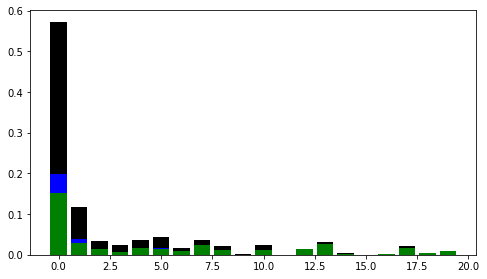

In [34]:
#fig, ax = plt.subplots()
#wepp_slice_plants[['COMPANY','MW']].groupby(['COMPANY']).sum().sort_values('MW', ascending=False)['MW'].hist(ax=ax, bins=100, bottom=0.1)


""" Degree Distribution"""

slice_df = wepp_slice_plants[['COMPANY','MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False)
#print slice_df
slice_df['all_count'] = wepp_slice_plants[['COMPANY','MW']].groupby('COMPANY').count()
slice_df['green'] = wepp_slice_plants.loc[wepp_slice_plants.green==True,['COMPANY','MW']].groupby('COMPANY').sum()
slice_df['blue'] = wepp_slice_plants.loc[wepp_slice_plants.blue==True,['COMPANY','MW']].groupby('COMPANY').sum()
slice_df['ff'] = wepp_slice_plants.loc[wepp_slice_plants.ff==True,['COMPANY','MW']].groupby('COMPANY').sum()
slice_df['green_count'] = wepp_slice_plants.loc[wepp_slice_plants.green==True,['COMPANY','MW']].groupby('COMPANY').count()
slice_df['blue_count'] = wepp_slice_plants.loc[wepp_slice_plants.blue==True,['COMPANY','MW']].groupby('COMPANY').count()
slice_df['ff_count'] = wepp_slice_plants.loc[wepp_slice_plants.ff==True,['COMPANY','MW']].groupby('COMPANY').count()
#ax.plot(np.arange(len(slice_df)), slice_df['MW'].values, color='gray')
#ax.plot(np.arange(len(slice_df)), slice_df['green'].values, color='green')
#ax.plot(np.arange(len(slice_df)), slice_df['blue'].values, color='blue')
#ax.plot(np.arange(len(slice_df)), slice_df['ff'].values, color='black')
#ax.set_yscale("log", nonposy='clip')
#plt.show()
#print slice_df

#print slice_df['all_count'].max()
#print slice_df['MW'].max()

n_bins=20

bins_MW = [slice_df['MW'].max()/20.*ii for ii in range(n_bins+1)] #equal size bins??
#bins_MW.insert(0,0.0001)
bins_count = [slice_df['all_count'].max()/20.*ii for ii in range(n_bins+1)] #equal size bins???
#print bins_count

dd_count = np.zeros((len(bins_count)-1,4))
dd_sum = np.zeros((len(bins_MW)-1,4))

for b in range(n_bins):
    #print slice_df.loc[(slice_df.MW>bins_MW[b])&(slice_df.MW<bins_MW[b+1]),['all_count']].sum()
    dd_count[b,0] = slice_df.loc[(slice_df.MW>bins_count[b])&(slice_df.MW<=bins_count[b+1]),['all_count']].sum()
    dd_sum[b,0] = slice_df.loc[(slice_df.MW>bins_MW[b])&(slice_df.MW<=bins_MW[b+1]),['MW']].sum()
    dd_count[b,1] = slice_df.loc[(slice_df.MW>bins_count[b])&(slice_df.MW<=bins_count[b+1]),['green_count']].sum()
    dd_sum[b,1] = slice_df.loc[(slice_df.MW>bins_MW[b])&(slice_df.MW<=bins_MW[b+1]),['green']].sum()
    dd_count[b,2] = slice_df.loc[(slice_df.MW>bins_count[b])&(slice_df.MW<=bins_count[b+1]),['blue_count']].sum()
    dd_sum[b,2] = slice_df.loc[(slice_df.MW>bins_MW[b])&(slice_df.MW<=bins_MW[b+1]),['blue']].sum()
    dd_count[b,3] = slice_df.loc[(slice_df.MW>bins_count[b])&(slice_df.MW<=bins_count[b+1]),['ff_count']].sum()
    dd_sum[b,3] = slice_df.loc[(slice_df.MW>bins_MW[b])&(slice_df.MW<=bins_MW[b+1]),['ff']].sum()
    
print 'initail shape', dd_sum.shape
    
dd_count = np.nan_to_num(dd_count)
dd_sum = np.nan_to_num(dd_sum)
    
print dd_count[:,0]
print dd_count[:,1]
print dd_count[:,2]
print dd_count[:,3]
print dd_sum[:,0]
print dd_sum[:,1]
print dd_sum[:,2]
print dd_sum[:,3]

dd_sum = dd_sum/ np.sum(dd_sum, axis=0)[0]
dd_count = dd_count/ np.sum(dd_count, axis=0)[0]

fig, ax = plt.subplots(figsize=(8,4.5))

x_pos = np.arange(n_bins)

cols_dict = {
    0:'green',
    1:'blue',
    2:'black',
}

bottom = np.zeros((n_bins))

print 'shapes:', x_pos.shape, bottom.shape

for c in range(3):
    ax.bar(x_pos, height=dd_count[:,c+1], width=0.8, bottom=bottom, color=cols_dict[c])
    bottom = bottom+dd_count[:,c+1]

#ax.set_yticks(y_pos)
#ax.set_yticklabels([(str(bins[b])+' - '+str(bins[b+1])) for b in range(len(bins)-1)])
##ax.invert_yaxis()  # labels read top-to-bottom
#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['Largest', '', 'Smallest'])
#ax.set_xlabel('Frequency')
#ax.set_title('Triads - Year + Country + Count / Sum')

plt.show()

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:49: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


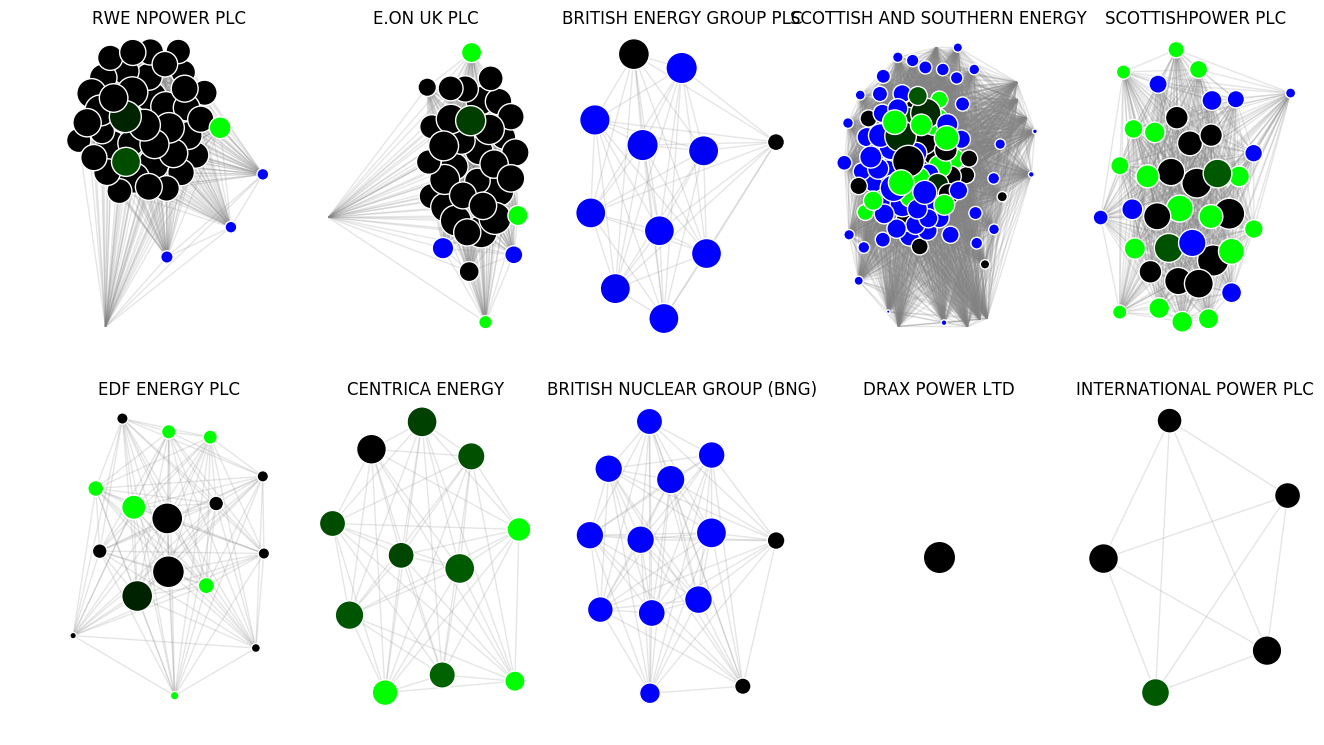

In [88]:
#for c in companies_ordered:
#    print len(wepp_slice_plants.loc[wepp_slice_plants['COMPANY']==c])

fig, axs = plt.subplots(2,5,figsize=(16,9 ), dpi=100)
ii=0
jj=0

for c in companies_ordered[0:10]:
    wepp_slice_company = wepp_slice_plants.loc[wepp_slice_plants['COMPANY']==c]
    #print wepp_slice_company
    
    # makem nodes
    
    nodes_list = []
    
    for plant in list(wepp_slice_company.index):
        g = int(wepp_slice_company.get_value(plant,'green_MW')/wepp_slice_company.get_value(plant,'MW')*255)
        b = int(wepp_slice_company.get_value(plant,'blue_MW')/wepp_slice_company.get_value(plant,'MW')*255)
        size=np.log10(wepp_slice_company.get_value(plant,'MW'))*10
    

        nodes_list.append(
            (plant,{
                'pos': np.random.rand(2),
                'type': 'power_station',
                'n_color':"#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)),
                'n_alpha':1.0,
                'n_size':size
                })            
            )
        
    #print nodes_list
        
    # makem edges
    
    edges_list = []
    
    pi=0
        
    for plant1 in list(wepp_slice_company.index):
        
        pi+=1
    
        for plant2 in list(wepp_slice_company.index)[pi:]:
            
            if plant1 != plant2:
                edges_list.append(
                    (plant1, plant2, {
                        'weight': 10.0*np.log10(min(wepp_slice_company.get_value(plant1,'MW'),wepp_slice_company.get_value(plant2,'MW'))),
                        'type': 'plants',
                        'e_color': 'gray',
                        'e_alpha': 1.0
                    })
                )
            
            
    ### make graph diagram
    
    G = nx.Graph()

    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    
    if len(edges_list)>0:
        max_weight= max([e[2]['weight'] for e in edges_list])
    else:
        max_weight=1

    



    #print nx.get_edge_attributes(G,'e_color')

    pos = nx.get_node_attributes(G,'pos')
    #print pos

    pos = nx.spring_layout(G, k=max_weight/8.0, iterations=50, pos=pos, center=[0,0], weight='weight')#fixed=fixed_nodes, 


    ### Draw Edges
    nx.draw_networkx_edges(G,
                               pos,
                               edgelist =G.edges(),
                               ax=axs[jj,ii],
                               edge_color=[nx.get_edge_attributes(G,'e_color')[e] for e in G.edges()],
                               alpha=0.2
                              )
        
    ### Draw Nodes
    nodes_ax = nx.draw_networkx_nodes(G,
                                          pos,
                                          ax=axs[jj,ii],
                                          nodelist=G.nodes(),
                                          node_size = [nx.get_node_attributes(G,'n_size')[n]*15 for n in G.nodes()],
                                          node_color = [nx.get_node_attributes(G,'n_color')[n] for n in G.nodes()],
                                          alpha= [nx.get_node_attributes(G,'n_alpha')[n] for n in G.nodes()]
                                          )
        
             

    nodes_ax.set_edgecolor('w')
    
    axs[jj,ii].set_title(c)


    axs[jj,ii].axis('off')
    
    ii+=1
    if ii==5:
        ii=0
        jj=1

    #fig.savefig('./figures/country_layer/language_spring.png')
plt.show()
                
    
 
    #print nodes_list

In [31]:
short_list = [c for c in list(company_meta[company_meta.COUNT==2].index)]
print len(short_list)

slice_2_0 = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW').groupby('COMPANY').nth(0)
slice_2_1 = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW').groupby('COMPANY').nth(1)

#print green_2
#print blue_2
#print ff_2
print slice_2_1.sort_values('MW')
print slice_2_0.sort_values('MW')

38
                                      MW   blue     ff  green
COMPANY                                                      
ADVANTICA TECHNOLOGIES LTD         0.030  False   True  False
MENDIP POWER GROUP                 0.075   True  False  False
SIR WILLIAM LITHGOW                0.109   True  False  False
RURAL GENERATION LTD               0.120  False  False   True
PEABODY TRUST                      0.157  False  False   True
SHP PROJECTS LTD                   0.250   True  False  False
RADISSON SAS                       0.300  False   True  False
BOROUGH OF HAVERING                0.700  False   True  False
HIGHLAND LIGHT AND POWER LTD       1.000   True  False  False
WYVERN WASTE SERVICES LTD          1.600  False  False   True
FORD MOTOR CO LTD                  1.685  False   True   True
YORWASTE LTD                       2.000  False  False   True
CAIRN ENERGY                       2.000  False   True  False
SCOTTISH WATER                     2.600  False  False   True
UNIVE

27
                                    MW   blue     ff  green
COMPANY                                                    
AIRBUS                           3.000  False   True  False
AIRTRICITY LTD                  72.000  False  False   True
AMEC WIND                        5.500  False  False   True
ARJO WIGGINS                    18.600  False   True  False
BG GROUP PLC                    24.000  False   True  False
BLUE CIRCLE INDUSTRIES           3.000  False  False   True
BP PLC                          19.000  False   True  False
BRITISH VIRGIN ISLANDS ELEC     17.224  False   True  False
CORUS                           53.780  False   True  False
DERWENT HYDROELECTRIC POWER      0.200   True  False  False
DULAS LTD                        0.285   True  False  False
ENERGETICA                       6.400  False   True  False
FRED OLSEN RENEWABLES LTD       62.500  False  False   True
GLAXO WELLCOME UK LTD           12.000  False   True  False
HAINSFORD ENERGY LTD            16.00

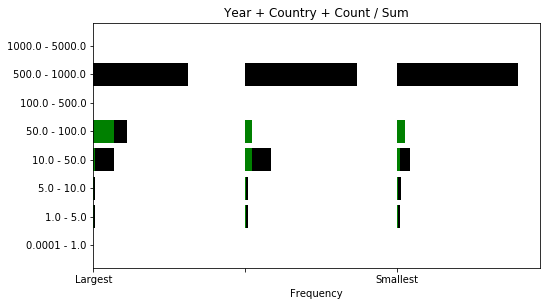

In [94]:
""" make feq hbar - triangle"""

short_list = [c for c in list(company_meta[company_meta.COUNT==3].index)]
print len(short_list)

#slice_2_0 = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW').groupby('COMPANY').nth(0)
#slice_2_1 = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW').groupby('COMPANY').nth(1)

slice_3 = {}

slice_3[0] = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW', ascending=False).groupby('COMPANY').nth(0)
slice_3[1] = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW', ascending=False).groupby('COMPANY').nth(1)
slice_3[2] = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW', ascending=False).groupby('COMPANY').nth(2)


#print green_2
#print blue_2
#print ff_2
#print slice_3_2.sort_values('MW')
#print slice_3_1.sort_values('MW')
#print slice_3_0.sort_values('MW')

bins = [0.0001,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0]
dd_count = np.zeros((len(bins)-1,3,3))
dd_sum = np.zeros((len(bins)-1,3,3))

for l in range(3):
    for b in range(1,len(bins)):
    
        #print bins[b]
        dd_sum[b-1,0,l]= (slice_3[l].loc[(slice_3[l].MW>bins[b-1])&(slice_3[l].MW<=bins[b])&(slice_3[l].green==True),'MW'].sum())
        dd_count[b-1,0,l] =(slice_3[l].loc[(slice_3[l].MW>bins[b-1])&(slice_3[l].MW<=bins[b])&(slice_3[l].green==True),'MW'].count())
        dd_sum[b-1,1,l]= (slice_3[l].loc[(slice_3[l].MW>bins[b-1])&(slice_3[l].MW<=bins[b])&(slice_3[l].blue==True),'MW'].sum())
        dd_count[b-1,1,l]= (slice_3[l].loc[(slice_3[l].MW>bins[b-1])&(slice_3[l].MW<=bins[b])&(slice_3[l].blue==True),'MW'].count())
        dd_sum[b-1,2,l] =(slice_3[l].loc[(slice_3[l].MW>bins[b-1])&(slice_3[l].MW<=bins[b])&(slice_3[l].ff==True),'MW'].sum())
        dd_count[b-1,2,l]= (slice_3[l].loc[(slice_3[l].MW>bins[b-1])&(slice_3[l].MW<=bins[b])&(slice_3[l].ff==True),'MW'].count())

        
dd_sum = np.nan_to_num(dd_sum)

print slice_3[0]
print slice_3[2]

dd_sum = (dd_sum/np.sum(dd_sum, axis=(0,1)))
dd_count = (dd_count/np.sum(dd_count, axis=(0,1)))

## make freq bars
fig, ax = plt.subplots(figsize=(8,4.5))

y_pos = np.arange(len(bins)-1)

cols_dict = {
    0:'green',
    1:'blue',
    2:'black',
}

for l in range(3):
    left = np.full(len(bins)-1,l+0.5)
    for c in range(3):
        ax.barh(y_pos, width=dd_sum[:,c,l], height=0.8, left=left, color=cols_dict[c])
        left = left+dd_sum[:,c,l]

ax.set_yticks(y_pos)
ax.set_yticklabels([(str(bins[b])+' - '+str(bins[b+1])) for b in range(len(bins)-1)])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['Largest', '', 'Smallest'])
ax.set_xlabel('Frequency')
ax.set_title('Triads - Year + Country + Count / Sum')

plt.show()

38
                                      MW   blue     ff  green
COMPANY                                                      
ADVANTICA TECHNOLOGIES LTD         0.030  False   True  False
BARCLAYS BANK                      5.700  False   True  False
BOROUGH OF HAVERING                0.700  False   True  False
BRITISH GAS                       14.540  False   True  False
CAIRN ENERGY                       2.000  False   True  False
CONOCOPHILLIPS CO                 49.400  False   True  False
DISTRICT ENERGY LTD               10.000  False   True  False
DONG (UK) LTD                     90.000  False  False   True
ENERGIEKONTOR AG                   3.900  False  False   True
FALCK RENEWABLES LTD              58.500  False  False   True
FIRST HYDRO CO                  1890.000   True  False  False
FORD MOTOR CO LTD                  1.685  False   True   True
GREATER MANCHESTER WASTE LTD      10.480  False  False   True
HARRODS                            4.176  False   True  False
HARWO

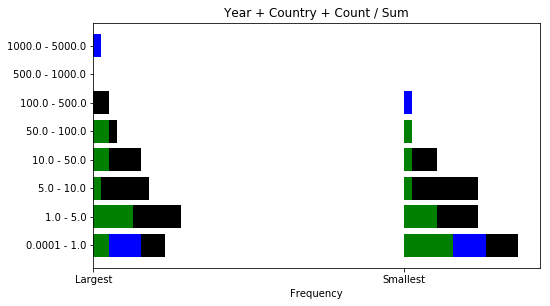

In [96]:
""" make feq hbar - diad"""

short_list = [c for c in list(company_meta[company_meta.COUNT==2].index)]
print len(short_list)

#slice_2_0 = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW').groupby('COMPANY').nth(0)
#slice_2_1 = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW').groupby('COMPANY').nth(1)

slice_2 = {}

slice_2[0] = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW', ascending=False).groupby('COMPANY').nth(0)
slice_2[1] = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW', ascending=False).groupby('COMPANY').nth(1)


#print green_2
#print blue_2
#print ff_2
#print slice_2_2.sort_values('MW')
#print slice_2_1.sort_values('MW')
#print slice_2_0.sort_values('MW')

bins = [0.0001,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0]
dd_count = np.zeros((len(bins)-1,3,2))
dd_sum = np.zeros((len(bins)-1,3,2))

for l in range(2):
    for b in range(1,len(bins)):
    
        #print bins[b]
        dd_sum[b-1,0,l]= (slice_2[l].loc[(slice_2[l].MW>bins[b-1])&(slice_2[l].MW<=bins[b])&(slice_2[l].green==True),'MW'].sum())
        dd_count[b-1,0,l] =(slice_2[l].loc[(slice_2[l].MW>bins[b-1])&(slice_2[l].MW<=bins[b])&(slice_2[l].green==True),'MW'].count())
        dd_sum[b-1,1,l]= (slice_2[l].loc[(slice_2[l].MW>bins[b-1])&(slice_2[l].MW<=bins[b])&(slice_2[l].blue==True),'MW'].sum())
        dd_count[b-1,1,l]= (slice_2[l].loc[(slice_2[l].MW>bins[b-1])&(slice_2[l].MW<=bins[b])&(slice_2[l].blue==True),'MW'].count())
        dd_sum[b-1,2,l] =(slice_2[l].loc[(slice_2[l].MW>bins[b-1])&(slice_2[l].MW<=bins[b])&(slice_2[l].ff==True),'MW'].sum())
        dd_count[b-1,2,l]= (slice_2[l].loc[(slice_2[l].MW>bins[b-1])&(slice_2[l].MW<=bins[b])&(slice_2[l].ff==True),'MW'].count())

        
dd_sum = np.nan_to_num(dd_sum)

print slice_2[0]
print slice_2[1]

dd_sum = (dd_sum/np.sum(dd_sum, axis=(0,1)))
dd_count = (dd_count/np.sum(dd_count, axis=(0,1)))

## make freq bars
fig, ax = plt.subplots(figsize=(8,4.5))

y_pos = np.arange(len(bins)-1)

cols_dict = {
    0:'green',
    1:'blue',
    2:'black',
}

for l in range(2):
    left = np.full(len(bins)-1,l+0.5)
    for c in range(3):
        ax.barh(y_pos, width=dd_count[:,c,l], height=0.8, left=left, color=cols_dict[c])
        left = left+dd_count[:,c,l]

ax.set_yticks(y_pos)
ax.set_yticklabels([(str(bins[b])+' - '+str(bins[b+1])) for b in range(len(bins)-1)])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Largest', 'Smallest'])
ax.set_xlabel('Frequency')
ax.set_title('Diads - Year + Country + Count / Sum')

plt.show()

601
                                     MW   blue     ff  green
COMPANY                                                     
3C WASTE LTD                      0.875  False  False   True
A PEARSON & SONS                  1.700  False   True  False
ABBEY PRODUCE LTD                 0.225  False  False   True
ABERGAVENNY LEISURE CENTRE        0.045  False   True  False
AES (NI) LTD                    578.000  False   True  False
AGRILEC LTD                       1.020  False  False   True
AIREDALE HOSPITAL                 0.320  False   True  False
ALBREW MALSTERS                   0.750  False   True  False
ALDERNEY ELECTRICITY LTD          1.000  False   True  False
ALLIED COLLOIDS                  14.300  False   True  False
ALPHABEDS                         0.024   True  False  False
ALSTOM CAPTIVE POWER              5.500  False   True  False
ALTON SPORTS CENTRE               0.045  False   True  False
ALVASTON HALL HOTEL               0.045  False   True  False
ANCHOR NURSERIES    

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in divide
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide


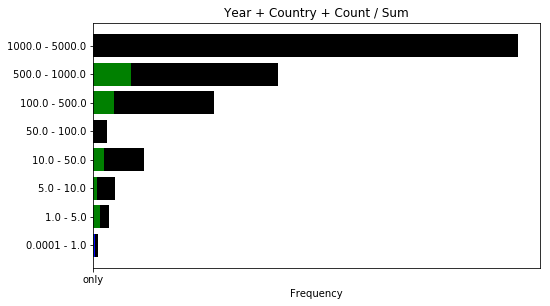

In [98]:
""" make feq hbar - isolate"""

short_list = [c for c in list(company_meta[company_meta.COUNT==1].index)]
print len(short_list)

#slice_1_0 = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW').groupby('COMPANY').nth(0)
#slice_1_1 = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW').groupby('COMPANY').nth(1)

slice_1 = {}

slice_1[0] = wepp_slice_plants[wepp_slice_plants['COMPANY'].isin(short_list)][['COMPANY','MW','green','blue','ff']].sort_values('MW', ascending=False).groupby('COMPANY').nth(0)



bins = [0.0001,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0]
dd_count = np.zeros((len(bins)-1,3,2))
dd_sum = np.zeros((len(bins)-1,3,2))

for l in range(1):
    for b in range(1,len(bins)):
    
        #print bins[b]
        dd_sum[b-1,0,l]= (slice_1[l].loc[(slice_1[l].MW>bins[b-1])&(slice_1[l].MW<=bins[b])&(slice_1[l].green==True),'MW'].sum())
        dd_count[b-1,0,l] =(slice_1[l].loc[(slice_1[l].MW>bins[b-1])&(slice_1[l].MW<=bins[b])&(slice_1[l].green==True),'MW'].count())
        dd_sum[b-1,1,l]= (slice_1[l].loc[(slice_1[l].MW>bins[b-1])&(slice_1[l].MW<=bins[b])&(slice_1[l].blue==True),'MW'].sum())
        dd_count[b-1,1,l]= (slice_1[l].loc[(slice_1[l].MW>bins[b-1])&(slice_1[l].MW<=bins[b])&(slice_1[l].blue==True),'MW'].count())
        dd_sum[b-1,2,l] =(slice_1[l].loc[(slice_1[l].MW>bins[b-1])&(slice_1[l].MW<=bins[b])&(slice_1[l].ff==True),'MW'].sum())
        dd_count[b-1,2,l]= (slice_1[l].loc[(slice_1[l].MW>bins[b-1])&(slice_1[l].MW<=bins[b])&(slice_1[l].ff==True),'MW'].count())

        
dd_sum = np.nan_to_num(dd_sum)

print slice_1[0]


dd_sum = (dd_sum/np.sum(dd_sum, axis=(0,1)))
dd_count = (dd_count/np.sum(dd_count, axis=(0,1)))

## make freq bars
fig, ax = plt.subplots(figsize=(8,4.5))

y_pos = np.arange(len(bins)-1)

cols_dict = {
    0:'green',
    1:'blue',
    2:'black',
}

for l in range(1):
    left = np.full(len(bins)-1,l+0.5)
    for c in range(3):
        ax.barh(y_pos, width=dd_sum[:,c,l], height=0.8, left=left, color=cols_dict[c])
        left = left+dd_sum[:,c,l]

ax.set_yticks(y_pos)
ax.set_yticklabels([(str(bins[b])+' - '+str(bins[b+1])) for b in range(len(bins)-1)])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xticks([0.5])
ax.set_xticklabels(['only'])
ax.set_xlabel('Frequency')
ax.set_title('Isolates - Year + Country + Count / Sum')

plt.show()